# QUESTION 11 - Maria Oros

The file obp.csv provided at https://questionnaire-148920.appspot.com/qas/obp.csv
contains 15 columns:
1.  Name - player’s name
2. playerid - player’s Fangraphs ID
3. birth_date - player’s date of birth
4. PA_21 - player’s plate appearances in 2021
5. OBP_21 - player’s on-base percentage in 2021
6. PA_20 - player’s plate appearances in 2020
7. OBP_20 - player’s on-base percentage in 2020
8. PA_19 - player’s plate appearances in 2019
9. OBP_19 - player’s on-base percentage in 2019
10. PA_18 - player’s plate appearances in 2018
11. OBP_18 - player’s on-base percentage in 2018
12. PA_17 - player’s plate appearances in 2017
13. OBP_17 - player’s on-base percentage in 2017
14. PA_16 - player’s plate appearances in 2016
15. OBP_16 - player’s on-base percentage in 2016

Instructions:
1. Predict each player’s on-base percentage in the 2021 season given his plate
appearances and on-base percentages in prior seasons.
2. Your submission will be judged primarily on the clarity with which you describe
your methodology and present your findings and secondarily on the accuracy of
your predictions.
3. You are definitely not required to do so, but if you wish, you are welcome to
research and incorporate more data than what is provided in the obp.csv file for
your predictions. However, you may not include any data from Opening Day for the
2021 regular season onward. For example, you may include each player’s exit
velocity in prior seasons if you can find that data and think it will help your prediction, but you cannot include each player’s 2021 exit velocity. Data in obp.csv came from fangraphs.com.
4. Feel free to use any approach, programming language, or software you prefer.
5. Feel free to use any mechanism(s) to present your results (email, LaTex, R
Markdown, Jupyter notebook, Powerpoint, etc.) so long as you describe your
methodology, include any code, and provide a measurement of the accuracy of your
predictions. Your analysis should be completely reproducible.
6. Using online resources such as Stack Overflow is encouraged! Just please include a citation (by including a comment in your code with a link to the resource).

# Maria Oros - Data Scientist maria.oros1202@gmail.com

In [33]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)

### Install my libraries

In [ ]:
pip install pymc3

In [12]:
pip install pybaseball

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.3.0
    Uninstalling PyJWT-2.3.0:
      Successfully uninstalled PyJWT-2.3.0


In [13]:
import pandas as pd
import os
import numpy as np
from pybaseball import batting_stats

# Analysis

## The data

### **Procedure Explanation**

PROCEDURE: In this first part I analyzed the row data to
* 1) I Explore the variables and its descriptive statistics to make sense of the nature of data and explore any previous outliers. An important aspec is to understand the missing values. Looks like not all players participate in all seasons, thats wahy both PA and OBP are missings in the same year. So we had consistency by missing associated to apparently the same cause (good!). At the same time 66v players had no previous information of PA in any f the seasons, so then would be not possible to predict 21 for them, I decide to exclude them.  
* 2) Proceed with the descriptive phase. I plot the histograms to check out if the data is skewed of if it shows extreme values in PA and OBP per year. I later explore the correlations of the variables. From this, looks like PA from previous years is more correlated to OBP 21 (and respectives 19,18, etc). It also looks a linear relationship with OBP. It will be important to keep this variable.
* 3) Treating missings is a critical step. I evaluated the inputation but the data distributios is very sensitive to this because we are predicting per player. So then I decided to proceed on the creation of new variables as moving averages on time windows for 1y, 2y, 3y, etc from 2020 for PA and then for OBP. The new variables seem correlated with OBP as well as the original variables PA?20, PA_21, etc, seems that those are explaining the relationships correctly and look like good predictors too. I include the definition of those in the respective cells. I als include a new variable age (the age in 2020) as predictor to take the most from the birt_date input. The importance of each variable is evaluated and explained in the respective section.


### 1) Data Exploration

I save the input file in drive, I am reading it here for analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data=pd.read_csv("/content/drive/MyDrive/USA/PHILLIES-beisbal/obp.csv")
data.head()

,Name,playerid,birth_date,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,OBP_18,PA_17,OBP_17,PA_16,OBP_16
0,Trayce Thompson,9952,1991-03-15,35,0.400,NaN,NaN,NaN,NaN,137.0,0.162,55.0,0.218,262.0,0.302
1,Mike Trout,10155,1991-08-07,146,0.466,241.0,0.390,600.0,0.438,608.0,0.460,507.0,0.442,681.0,0.441
2,Bryce Harper,11579,1992-10-16,599,0.429,244.0,0.420,682.0,0.372,695.0,0.393,492.0,0.413,627.0,0.373
3,Chris Owings,10030,1991-08-12,50,0.420,44.0,0.318,196.0,0.209,309.0,0.272,386.0,0.299,466.0,0.315
4,Nick Fortes,21538,1996-11-11,34,0.353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The exploratory analysis allows us to understand if is required to treat the data before any modeling.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Name        572 non-null    object 
 1   playerid    572 non-null    int64  
 2   birth_date  572 non-null    object 
 3   PA_21       572 non-null    int64  
 4   OBP_21      572 non-null    float64
 5   PA_20       466 non-null    float64
 6   OBP_20      466 non-null    float64
 7   PA_19       437 non-null    float64
 8   OBP_19      437 non-null    float64
 9   PA_18       359 non-null    float64
 10  OBP_18      359 non-null    float64
 11  PA_17       298 non-null    float64
 12  OBP_17      298 non-null    float64
 13  PA_16       247 non-null    float64
 14  OBP_16      247 non-null    float64
dtypes: float64(11), int64(2), object(2)
memory usage: 67.2+ KB


In [35]:
data[features].describe()


,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,OBP_18,PA_17,OBP_17,PA_16,OBP_16
count,572.000000,572.000000,466.000000,466.000000,437.000000,437.000000,359.000000,359.000000,298.000000,298.000000,247.000000,247.000000
mean,307.697552,0.305063,130.309013,0.308564,340.210526,0.317229,351.242340,0.315638,360.073826,0.320215,352.283401,0.312822
std,199.056235,0.049787,78.407915,0.076315,213.749170,0.059095,221.195406,0.060890,228.938543,0.064021,238.651668,0.063639
min,30.000000,0.091000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,132.750000,0.277000,59.000000,0.272250,147.000000,0.297000,143.000000,0.287500,137.500000,0.293250,129.000000,0.292000
50%,271.500000,0.310000,129.000000,0.315000,337.000000,0.323000,367.000000,0.319000,386.000000,0.325500,354.000000,0.318000
75%,481.500000,0.337000,204.750000,0.354000,530.000000,0.350000,552.000000,0.346500,567.500000,0.354000,590.500000,0.352500
max,724.000000,0.466000,267.000000,0.667000,747.000000,0.500000,745.000000,0.667000,725.000000,0.625000,744.000000,0.500000


* data looks in a good shape in general, std is bigger in PA 16, 17 and 18 than 20 relative to its units.
* OBP keeps with low std relative to its units.

In [9]:
for x in [16, 17, 18, 19, 20, 21]:
  print(x, 572-len(data[(data['PA_'+str(x)].isna()) & (data['OBP_'+str(x)].isna())]))

16 247
17 298
18 359
19 437
20 466
21 572


Previous results shows that the missings on PA and OBP within the same year coincide, which suggest that not all players played in each of these year thts why both OBP and PA are simultaneously missing values per year


In [4]:
import pandas as pd
import numpy as np

# Check if some playes do not have information of previous seasons
columns_of_interest = ['PA_20', 'OBP_20', 'PA_19', 'OBP_19', 'PA_18', 'OBP_18', 'PA_17', 'OBP_17', 'PA_16', 'OBP_16']

# Usar dropna() con how='all'
df_cleaned = data.dropna(subset=columns_of_interest, how='all')

print('The total with at least non issing values on OBP and PA are: ',len(df_cleaned))

The total with at least non issing values on OBP and PA are:  506


**df_cleaned will be our data set**

In [175]:
import pandas as pd
import numpy as np

rows_with_all_missing = data[columns_of_interest].isna().all(axis=1)

df_all_missing = data[rows_with_all_missing]

#Those are the rows with missing information in previos years if PA and OBP
df_all_missing

,Name,playerid,birth_date,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,OBP_18,PA_17,OBP_17,PA_16,OBP_16
4,Nick Fortes,21538,1996-11-11,34,0.353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,Jose Siri,17452,1995-07-22,49,0.347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,Jonathan India,21523,1996-12-15,631,0.376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,Matt Vierling,21558,1996-09-16,77,0.364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,Alfonso Rivas,21560,1996-09-13,49,0.388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,Jose Godoy,15808,1994-10-13,40,0.225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
555,Kevin Smith,20242,1996-07-04,36,0.194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
557,Jake Hager,12198,1993-03-04,30,0.233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
567,Greg Deichmann,19872,1995-05-31,31,0.161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


66 with no previous information, for them we can use Age for example or other metrics but not PA here

### 2) Descriptive analysis

In [177]:
features= ['PA_21', 'OBP_21', 'PA_20', 'OBP_20',
       'PA_19', 'OBP_19', 'PA_18', 'OBP_18', 'PA_17', 'OBP_17', 'PA_16',
       'OBP_16']

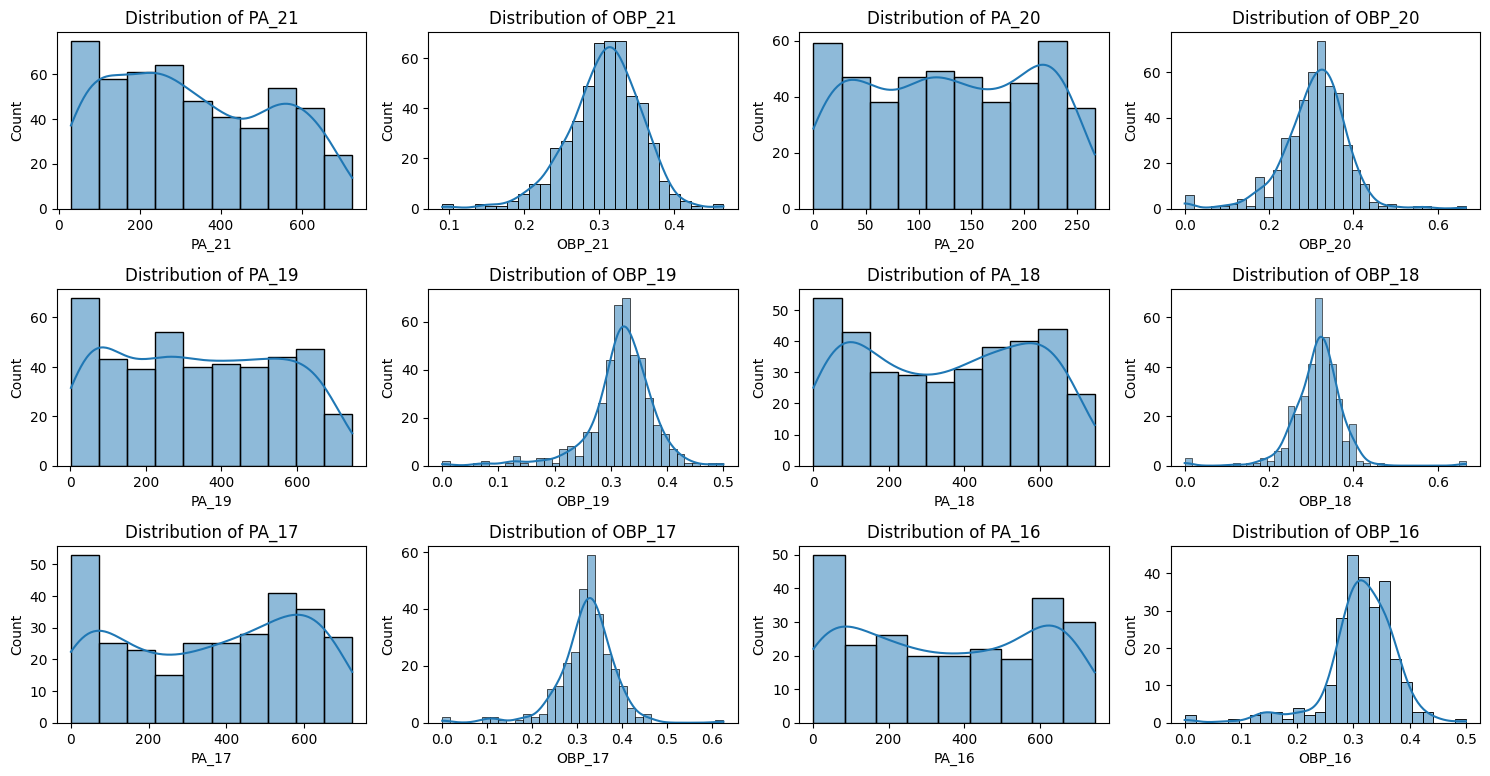

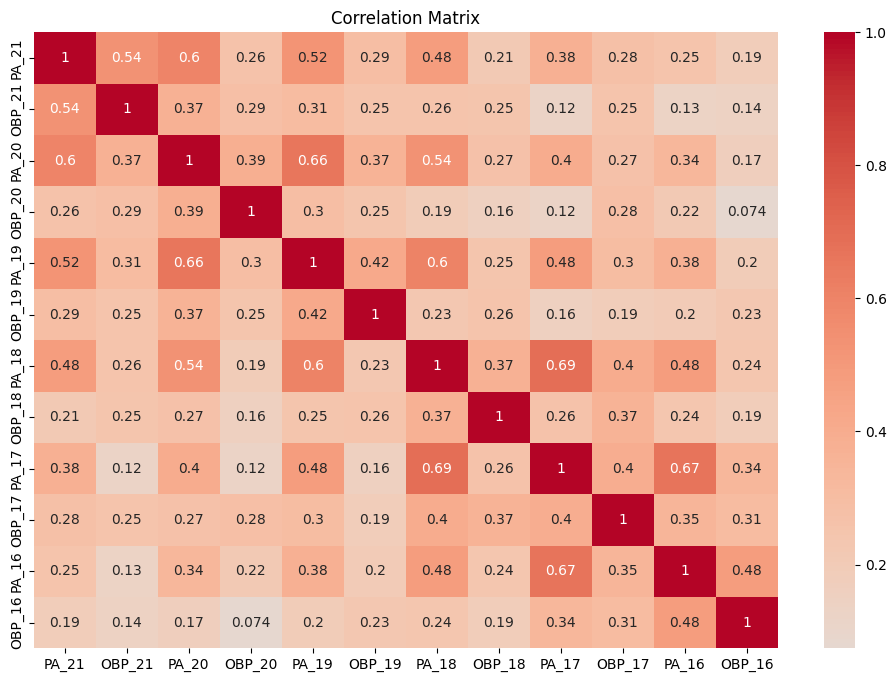

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt

key_variables = features

# Plotting distributions
plt.figure(figsize=(15, 10))
for i, var in enumerate(key_variables):
    plt.subplot(4, 4, i + 1)
    sns.histplot(df_cleaned[var], kde=True)
    plt.title(f'Distribution of {var}')
plt.tight_layout()
plt.show()

# Plotting correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = df_cleaned[key_variables].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


Proceed with the descriptive phase. I plot the histograms to check out if the data is skewed of if it shows extreme values in PA and OBP per year. OBP is normally distributed, some left skew is evident in all cases while PA looks more r skew.

I later explore the correlations of the variables. From this, looks like PA from previous years is high correlated to OBP 21 (and respectives 19,18, etc) and OBP20 to OBP21, previous OBP from previous years is less correlated in general.

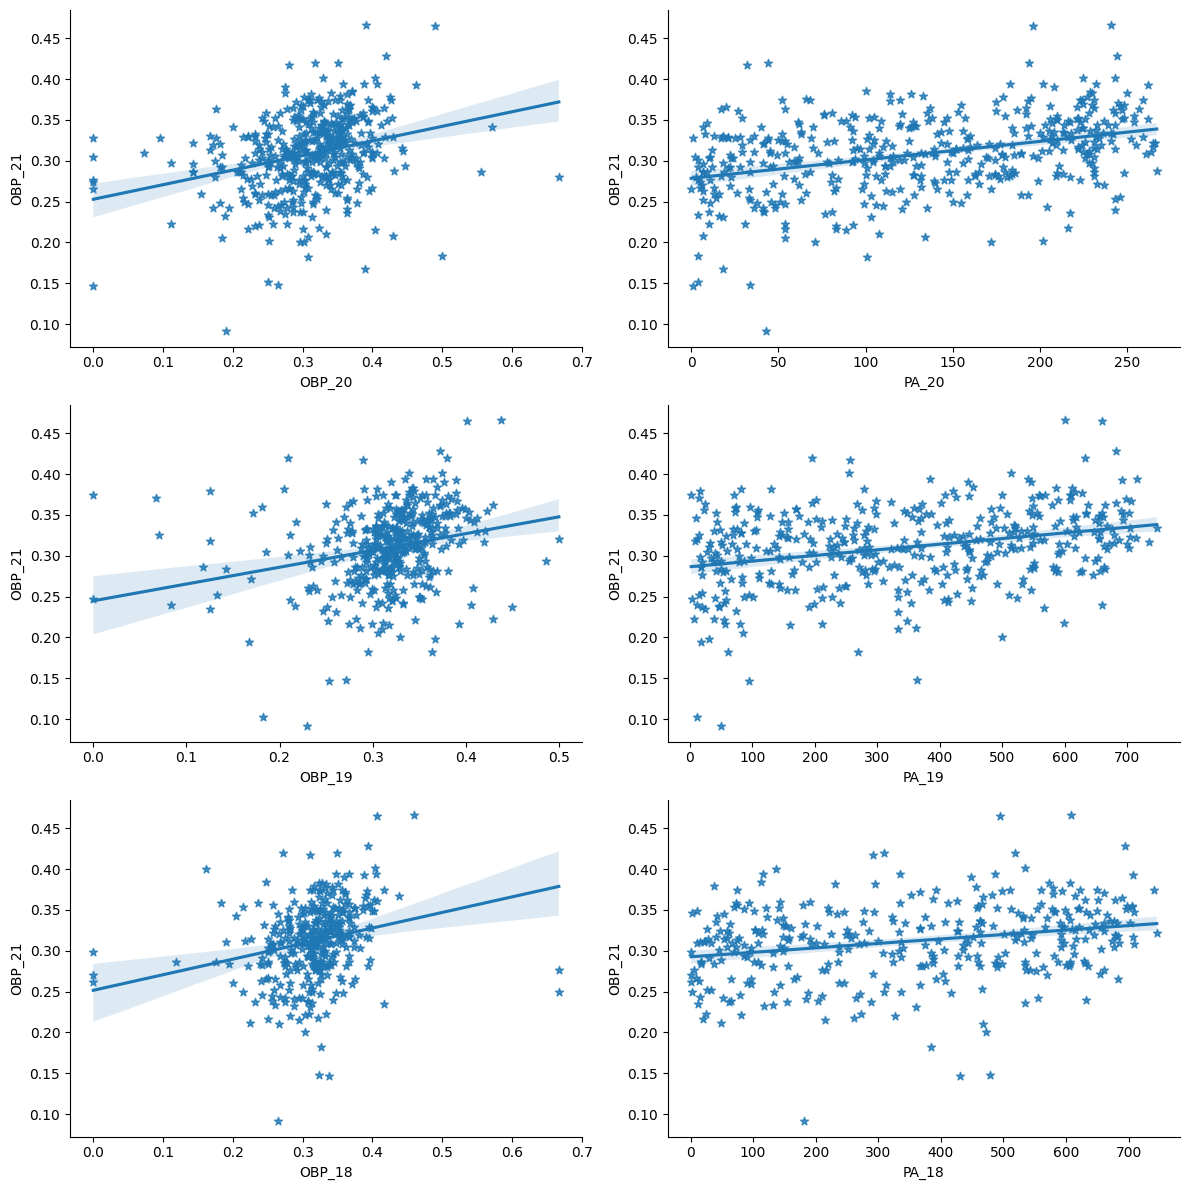

In [180]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


data2 = df_cleaned

fig = plt.figure(figsize=(12, 12))

# Create subplots
ax1 = fig.add_subplot(3, 2, 1)
ax2 = fig.add_subplot(3, 2, 2)
ax3 = fig.add_subplot(3, 2, 3)
ax4 = fig.add_subplot(3, 2, 4)
ax5 = fig.add_subplot(3, 2, 5)
ax6 = fig.add_subplot(3, 2, 6)

# Create regplots
sns.regplot(x="OBP_20", y="OBP_21", data=data2, scatter=True, marker="*", ax=ax1)
sns.regplot(x="PA_20", y="OBP_21", data=data2, scatter=True, marker="*", ax=ax2)
sns.regplot(x="OBP_19", y="OBP_21", data=data2, scatter=True, marker="*", ax=ax3)
sns.regplot(x="PA_19", y="OBP_21", data=data2, scatter=True, marker="*", ax=ax4)
sns.regplot(x="OBP_18", y="OBP_21", data=data2, scatter=True, marker="*", ax=ax5)
sns.regplot(x="PA_18", y="OBP_21", data=data2, scatter=True, marker="*", ax=ax6)

# Set axis labels
ax1.set_xlabel("OBP_20")
ax1.set_ylabel("OBP_21")
ax2.set_xlabel("PA_20")
ax2.set_ylabel("OBP_21")
ax3.set_xlabel("OBP_19")
ax3.set_ylabel("OBP_21")
ax4.set_xlabel("PA_19")
ax4.set_ylabel("OBP_21")
ax5.set_xlabel("OBP_18")
ax5.set_ylabel("OBP_21")
ax6.set_xlabel("PA_18")
ax6.set_ylabel("OBP_21")


sns.despine()
plt.tight_layout()

# Show plot
plt.show()


We corroborate the correlation, positive in such case, between PA and OBP.

OBP from pevious years is not so clear that is has a linear relationship with OBP21, aybe another approches and transformations might help.

### 3) Feature Engineering -- Missings treatment

In [151]:
pip install statsmodels

By conclusions above, the missing values represent that the player did not play in such season. However, is important to deal with the missings as some simple imputations could lead us to incorrect conclusions. This is the most critical part as the predictions needs to be by player.

So, before any impotation, I will try to retrieve aggregared statistics from previous years of PA and later for OBP. I wont touch PA21 and OBP21 as those are non missing and are our outcomes.

In [5]:
data_analysis = df_cleaned.copy()
data_analysis.head(5)

,Name,playerid,birth_date,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,OBP_18,PA_17,OBP_17,PA_16,OBP_16
0,Trayce Thompson,9952,1991-03-15,35,0.400,NaN,NaN,NaN,NaN,137.0,0.162,55.0,0.218,262.0,0.302
1,Mike Trout,10155,1991-08-07,146,0.466,241.0,0.390,600.0,0.438,608.0,0.460,507.0,0.442,681.0,0.441
2,Bryce Harper,11579,1992-10-16,599,0.429,244.0,0.420,682.0,0.372,695.0,0.393,492.0,0.413,627.0,0.373
3,Chris Owings,10030,1991-08-12,50,0.420,44.0,0.318,196.0,0.209,309.0,0.272,386.0,0.299,466.0,0.315
5,Juan Soto,20123,1998-10-25,654,0.465,196.0,0.490,659.0,0.401,494.0,0.406,NaN,NaN,NaN,NaN


In [200]:
len(data_analysis)

506

##### Building moving averages and related variables

DEFINITION:
* PA_1yr_avg is PA_20
* PA_2yr_avg is the average of PA on PA_20 and PA_19
For example for Trayce Thompson as PA_20 and PA_19 are both missings the PA_1yr_avg is missing
* PA_3yr_avg is the average of PA on PA_20, PA_19 and PA_18
* PA_4yr_avg is the average of PA on PA_20, PA_19, PA_18 and PA_17
* PA_5yr_avg is the average of PA on PA_20, PA_19, PA_18, PA_17 and PA_16

In [33]:
# mov avg
def rolling_avg(row, cols):
    # no nulls
    values = row[cols].dropna()
    if len(values) > 0:
        return np.mean(values)
    else:
        return np.nan

# Cols of interest PA
pa_columns = ['PA_20', 'PA_19', 'PA_18', 'PA_17', 'PA_16']

# Row values
for size in [1, 2, 3,4,5]:  # Time window 1,2,3 years
    col_names = pa_columns[:size]
    data_analysis[f'PA_{size}yr_avg'] = data_analysis.apply(lambda row: rolling_avg(row, col_names), axis=1)

data_analysis

,Name,playerid,birth_date,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,OBP_18,PA_17,OBP_17,PA_16,OBP_16,PA_1yr_avg,PA_2yr_avg,PA_3yr_avg,PA_4yr_avg,PA_5yr_avg
0,Trayce Thompson,9952,1991-03-15,35,0.400,NaN,NaN,NaN,NaN,137.0,0.162,55.0,0.218,262.0,0.302,NaN,NaN,137.000000,96.000000,151.333333
1,Mike Trout,10155,1991-08-07,146,0.466,241.0,0.390,600.0,0.438,608.0,0.460,507.0,0.442,681.0,0.441,241.0,420.5,483.000000,489.000000,527.400000
2,Bryce Harper,11579,1992-10-16,599,0.429,244.0,0.420,682.0,0.372,695.0,0.393,492.0,0.413,627.0,0.373,244.0,463.0,540.333333,528.250000,548.000000
3,Chris Owings,10030,1991-08-12,50,0.420,44.0,0.318,196.0,0.209,309.0,0.272,386.0,0.299,466.0,0.315,44.0,120.0,183.000000,233.750000,280.200000
5,Juan Soto,20123,1998-10-25,654,0.465,196.0,0.490,659.0,0.401,494.0,0.406,NaN,NaN,NaN,NaN,196.0,427.5,449.666667,449.666667,449.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,Albert Almora Jr.,14109,1994-04-16,54,0.148,34.0,0.265,363.0,0.271,479.0,0.323,323.0,0.338,117.0,0.308,34.0,198.5,292.000000,299.750000,263.200000
566,Luis Campusano,22217,1998-09-29,38,0.184,4.0,0.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,4.000000,4.000000,4.000000
568,Cameron Maybin,5223,1987-04-04,33,0.182,101.0,0.307,269.0,0.364,384.0,0.326,450.0,0.318,391.0,0.383,101.0,185.0,251.333333,301.000000,319.000000
570,Skye Bolt,17723,1994-01-15,60,0.103,NaN,NaN,11.0,0.182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,11.000000,11.000000,11.000000


In [202]:
data_analysis.columns

Index(['Name', 'playerid', 'birth_date', 'PA_21', 'OBP_21', 'PA_20', 'OBP_20',
       'PA_19', 'OBP_19', 'PA_18', 'OBP_18', 'PA_17', 'OBP_17', 'PA_16',
       'OBP_16', 'PA_1yr_avg', 'PA_2yr_avg', 'PA_3yr_avg', 'PA_4yr_avg',
       'PA_5yr_avg'],
      dtype='object')

In [203]:
data_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 506 entries, 0 to 571
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Name        506 non-null    object 
 1   playerid    506 non-null    int64  
 2   birth_date  506 non-null    object 
 3   PA_21       506 non-null    int64  
 4   OBP_21      506 non-null    float64
 5   PA_20       466 non-null    float64
 6   OBP_20      466 non-null    float64
 7   PA_19       437 non-null    float64
 8   OBP_19      437 non-null    float64
 9   PA_18       359 non-null    float64
 10  OBP_18      359 non-null    float64
 11  PA_17       298 non-null    float64
 12  OBP_17      298 non-null    float64
 13  PA_16       247 non-null    float64
 14  OBP_16      247 non-null    float64
 15  PA_1yr_avg  466 non-null    float64
 16  PA_2yr_avg  503 non-null    float64
 17  PA_3yr_avg  506 non-null    float64
 18  PA_4yr_avg  506 non-null    float64
 19  PA_5yr_avg  506 non-null    float6

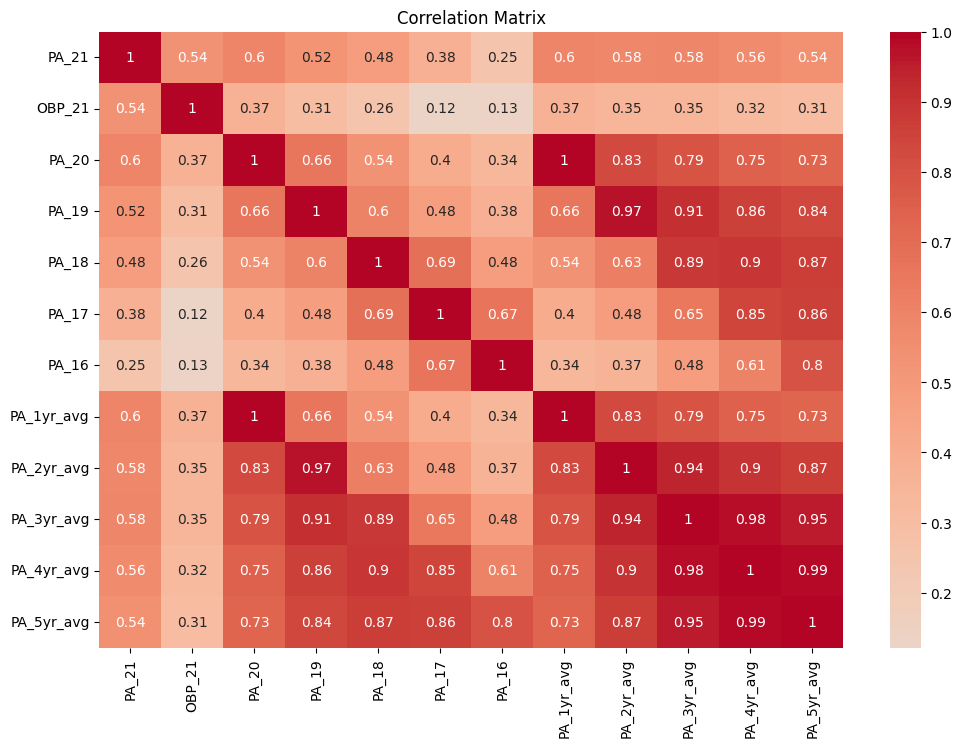

In [204]:
# Correlations
plt.figure(figsize=(12, 8))
corr_matrix = data_analysis[['PA_21', 'OBP_21', 'PA_20',
       'PA_19', 'PA_18', 'PA_17', 'PA_16',
       'PA_1yr_avg', 'PA_2yr_avg', 'PA_3yr_avg', 'PA_4yr_avg',
       'PA_5yr_avg']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

From this analysis, using the PA_3yr_avg is a good option as it has no missing values and the correlation with OBP_21 is almost as strong as PA_20 (.35 vs .37 respectively). Also preferable than PA_4yr_avg and PA_5yr_avg as time passes the correlation became weak, is preferable to count with fresh data when is the matter of temporal analysis.

DEFINITION:

* OBP_1yr_avg is OBP_20
* OBP_2yr_avg is the average of OBP on OBP_20 and OBP_19 For example for Trayce Thompson as OBP_20 and OBP_19 are both missings the OBP_1yr_avg is missing
* OBP_3yr_avg is the average of OBP on OBP_20, OBP_19 and OBP_18
* OBP_4yr_avg is the average of OBP on OBP_20, OBP_19, OBP_18 and OBP_17
* OBP_5yr_avg is the average of OBP on OBP_20, OBP_19, OBP_18, OBP_17 and OBP_16

In [34]:
pa_columns = ['OBP_20', 'OBP_19', 'OBP_18', 'OBP_17', 'OBP_16']


# Row values
for size in [1, 2, 3,4,5]:  # Time window 1,2,3 years
    col_names = pa_columns[:size]
    data_analysis[f'OBP_{size}yr_avg'] = data_analysis.apply(lambda row: rolling_avg(row, col_names), axis=1)

data_analysis

,Name,playerid,birth_date,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,...,PA_1yr_avg,PA_2yr_avg,PA_3yr_avg,PA_4yr_avg,PA_5yr_avg,OBP_1yr_avg,OBP_2yr_avg,OBP_3yr_avg,OBP_4yr_avg,OBP_5yr_avg
0,Trayce Thompson,9952,1991-03-15,35,0.400,NaN,NaN,NaN,NaN,137.0,...,NaN,NaN,137.000000,96.000000,151.333333,NaN,NaN,0.162000,0.190000,0.227333
1,Mike Trout,10155,1991-08-07,146,0.466,241.0,0.390,600.0,0.438,608.0,...,241.0,420.5,483.000000,489.000000,527.400000,0.390,0.4140,0.429333,0.432500,0.434200
2,Bryce Harper,11579,1992-10-16,599,0.429,244.0,0.420,682.0,0.372,695.0,...,244.0,463.0,540.333333,528.250000,548.000000,0.420,0.3960,0.395000,0.399500,0.394200
3,Chris Owings,10030,1991-08-12,50,0.420,44.0,0.318,196.0,0.209,309.0,...,44.0,120.0,183.000000,233.750000,280.200000,0.318,0.2635,0.266333,0.274500,0.282600
5,Juan Soto,20123,1998-10-25,654,0.465,196.0,0.490,659.0,0.401,494.0,...,196.0,427.5,449.666667,449.666667,449.666667,0.490,0.4455,0.432333,0.432333,0.432333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,Albert Almora Jr.,14109,1994-04-16,54,0.148,34.0,0.265,363.0,0.271,479.0,...,34.0,198.5,292.000000,299.750000,263.200000,0.265,0.2680,0.286333,0.299250,0.301000
566,Luis Campusano,22217,1998-09-29,38,0.184,4.0,0.500,NaN,NaN,NaN,...,4.0,4.0,4.000000,4.000000,4.000000,0.500,0.5000,0.500000,0.500000,0.500000
568,Cameron Maybin,5223,1987-04-04,33,0.182,101.0,0.307,269.0,0.364,384.0,...,101.0,185.0,251.333333,301.000000,319.000000,0.307,0.3355,0.332333,0.328750,0.339600
570,Skye Bolt,17723,1994-01-15,60,0.103,NaN,NaN,11.0,0.182,NaN,...,NaN,11.0,11.000000,11.000000,11.000000,NaN,0.1820,0.182000,0.182000,0.182000


In [35]:
data_analysis.columns

Index(['Name', 'playerid', 'birth_date', 'PA_21', 'OBP_21', 'PA_20', 'OBP_20',
       'PA_19', 'OBP_19', 'PA_18', 'OBP_18', 'PA_17', 'OBP_17', 'PA_16',
       'OBP_16', 'PA_1yr_avg', 'PA_2yr_avg', 'PA_3yr_avg', 'PA_4yr_avg',
       'PA_5yr_avg', 'OBP_1yr_avg', 'OBP_2yr_avg', 'OBP_3yr_avg',
       'OBP_4yr_avg', 'OBP_5yr_avg'],
      dtype='object')

In [207]:
data_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 506 entries, 0 to 571
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         506 non-null    object 
 1   playerid     506 non-null    int64  
 2   birth_date   506 non-null    object 
 3   PA_21        506 non-null    int64  
 4   OBP_21       506 non-null    float64
 5   PA_20        466 non-null    float64
 6   OBP_20       466 non-null    float64
 7   PA_19        437 non-null    float64
 8   OBP_19       437 non-null    float64
 9   PA_18        359 non-null    float64
 10  OBP_18       359 non-null    float64
 11  PA_17        298 non-null    float64
 12  OBP_17       298 non-null    float64
 13  PA_16        247 non-null    float64
 14  OBP_16       247 non-null    float64
 15  PA_1yr_avg   466 non-null    float64
 16  PA_2yr_avg   503 non-null    float64
 17  PA_3yr_avg   506 non-null    float64
 18  PA_4yr_avg   506 non-null    float64
 19  PA_5yr_avg   

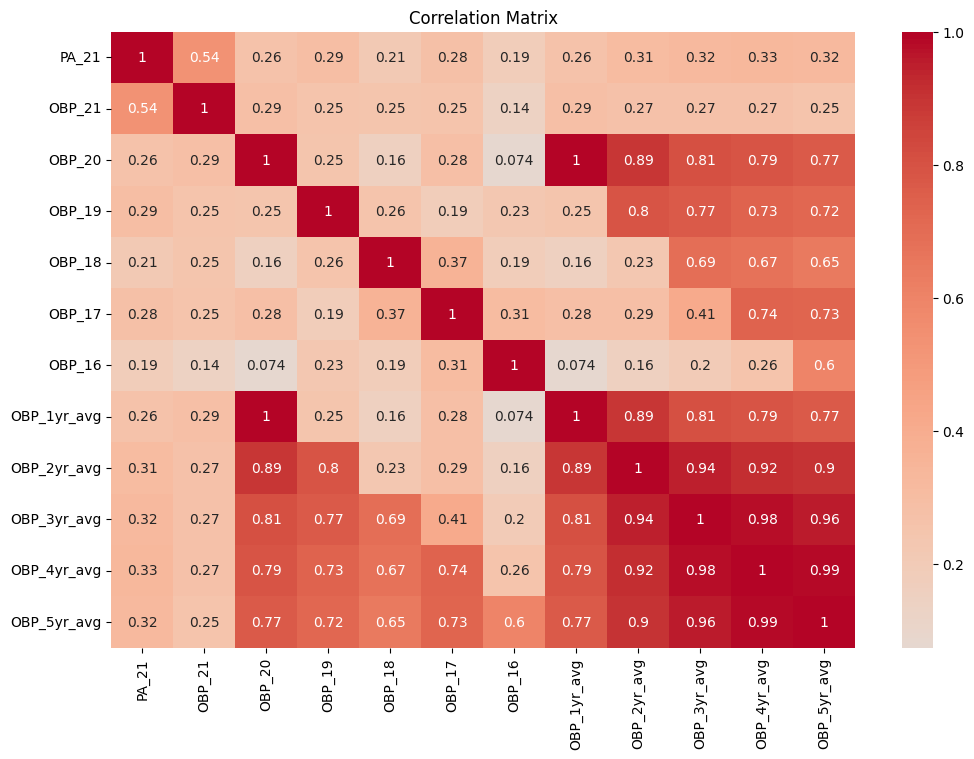

In [208]:
# Correlations
plt.figure(figsize=(12, 8))
corr_matrix = data_analysis[['PA_21', 'OBP_21', 'OBP_20',
       'OBP_19', 'OBP_18', 'OBP_17', 'OBP_16',
       'OBP_1yr_avg', 'OBP_2yr_avg', 'OBP_3yr_avg',
       'OBP_4yr_avg', 'OBP_5yr_avg']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

From this analysis, using the PA_3yr_avg is a good option as it has no missing values and the correlation with OBP_21 is almost as strong as PA_20 (.35 vs .37 respectively).

In [209]:
len(data_analysis)

506

##### Trends

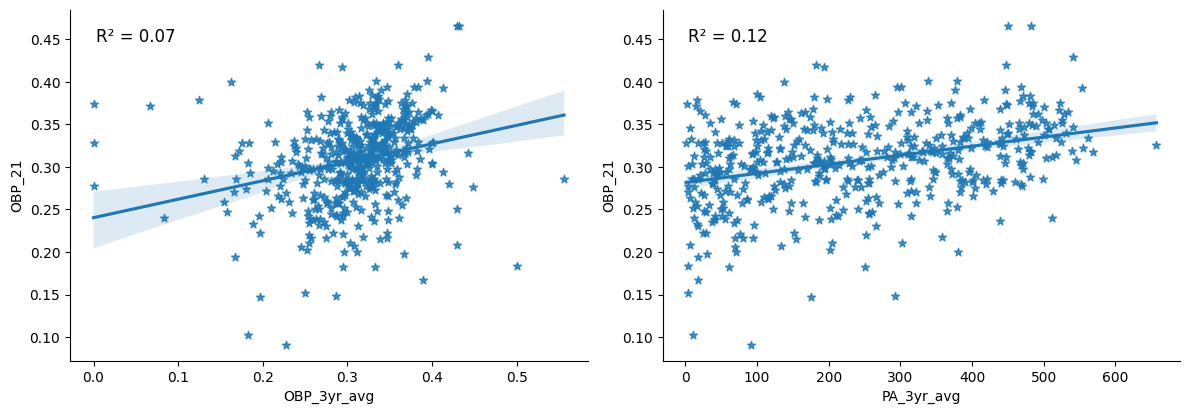

In [210]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


# Create subplots
fig = plt.figure(figsize=(12, 12))

# Define subplots
ax1 = fig.add_subplot(3, 2, 1)
ax2 = fig.add_subplot(3, 2, 2)
#ax3 = fig.add_subplot(3, 2, 3)
#ax4 = fig.add_subplot(3, 2, 4)
#ax5 = fig.add_subplot(3, 2, 5)
#ax6 = fig.add_subplot(3, 2, 6)

# Define a function to calculate and plot R2 values
def plot_with_r2(x, y, ax, xlabel, ylabel):
    sns.regplot(x=x, y=y, data=data_analysis, scatter=True, marker="*", ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    model = LinearRegression().fit(data_analysis[[x]], data2[y])
    predictions = model.predict(data_analysis[[x]])
    r2 = r2_score(data2[y], predictions)
    ax.text(0.05, 0.95, f'R² = {r2:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

# Create regplots with R2 values
plot_with_r2("OBP_3yr_avg", "OBP_21", ax1, "OBP_3yr_avg", "OBP_21")
plot_with_r2("PA_3yr_avg", "OBP_21", ax2, "PA_3yr_avg", "OBP_21")
#plot_with_r2("OBP_19", "OBP_21", ax3, "OBP_19", "OBP_21")
#plot_with_r2("PA_19", "OBP_21", ax4, "PA_19", "OBP_21")
#plot_with_r2("OBP_18", "OBP_21", ax5, "OBP_18", "OBP_21")
#plot_with_r2("PA_18", "OBP_21", ax6, "PA_18", "OBP_21")

sns.despine()
plt.tight_layout()

# Show plot
plt.show()


We have a linear trend as with PA, OBP looks less linear but still capturing the similar amount of variance.

In [211]:
len(data_analysis)

506

#### Feature engineering - age data

In [65]:
import pandas as pd
from datetime import datetime

# Convert 'birth_date' from string to datetime
data_analysis['birth_date'] = pd.to_datetime(data_analysis['birth_date'])

def calculate_age(birth_date, year):
    # Create a date for the birthday in 'year'
    birthday_that_year = datetime(year, birth_date.month, birth_date.day)

    # Calculate age by subtracting the birth year from the year in question
    age = year - birth_date.year

    if (birthday_that_year > datetime(year, 12, 31)):
        age -= 1

    return age

# Computing the years old of the player
for y in range(16, 22):
  specific_year=2000+y
  data_analysis['age_in_' + str(specific_year)] = data_analysis['birth_date'].apply(lambda x: calculate_age(x, specific_year))
data_analysis

,Name,playerid,birth_date,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,...,OBP_2yr_avg,OBP_3yr_avg,OBP_4yr_avg,OBP_5yr_avg,age_in_2016,age_in_2017,age_in_2018,age_in_2019,age_in_2020,age_in_2021
0,Trayce Thompson,9952,1991-03-15,35,0.400,NaN,NaN,NaN,NaN,137.0,...,NaN,0.162000,0.190000,0.227333,25,26,27,28,29,30
1,Mike Trout,10155,1991-08-07,146,0.466,241.0,0.390,600.0,0.438,608.0,...,0.4140,0.429333,0.432500,0.434200,25,26,27,28,29,30
2,Bryce Harper,11579,1992-10-16,599,0.429,244.0,0.420,682.0,0.372,695.0,...,0.3960,0.395000,0.399500,0.394200,24,25,26,27,28,29
3,Chris Owings,10030,1991-08-12,50,0.420,44.0,0.318,196.0,0.209,309.0,...,0.2635,0.266333,0.274500,0.282600,25,26,27,28,29,30
5,Juan Soto,20123,1998-10-25,654,0.465,196.0,0.490,659.0,0.401,494.0,...,0.4455,0.432333,0.432333,0.432333,18,19,20,21,22,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,Albert Almora Jr.,14109,1994-04-16,54,0.148,34.0,0.265,363.0,0.271,479.0,...,0.2680,0.286333,0.299250,0.301000,22,23,24,25,26,27
566,Luis Campusano,22217,1998-09-29,38,0.184,4.0,0.500,NaN,NaN,NaN,...,0.5000,0.500000,0.500000,0.500000,18,19,20,21,22,23
568,Cameron Maybin,5223,1987-04-04,33,0.182,101.0,0.307,269.0,0.364,384.0,...,0.3355,0.332333,0.328750,0.339600,29,30,31,32,33,34
570,Skye Bolt,17723,1994-01-15,60,0.103,NaN,NaN,11.0,0.182,NaN,...,0.1820,0.182000,0.182000,0.182000,22,23,24,25,26,27


In [66]:
data_analysis.to_parquet('/content/drive/MyDrive/USA/PHILLIES-beisbal/obp_2.parquet')

In [ ]:
datamodeling=data_analysis

len(datamodeling)

506

In [ ]:
datamodeling.columns

Index(['Name', 'playerid', 'birth_date', 'PA_21', 'OBP_21', 'PA_20', 'OBP_20',
       'PA_19', 'OBP_19', 'PA_18', 'OBP_18', 'PA_17', 'OBP_17', 'PA_16',
       'OBP_16', 'PA_1yr_avg', 'PA_2yr_avg', 'PA_3yr_avg', 'PA_4yr_avg',
       'PA_5yr_avg', 'OBP_1yr_avg', 'OBP_2yr_avg', 'OBP_3yr_avg',
       'OBP_4yr_avg', 'OBP_5yr_avg', 'age_in_2016', 'age_in_2017',
       'age_in_2018', 'age_in_2019', 'age_in_2020', 'age_in_2021'],
      dtype='object')

#### Correlations of the new variables and old variables


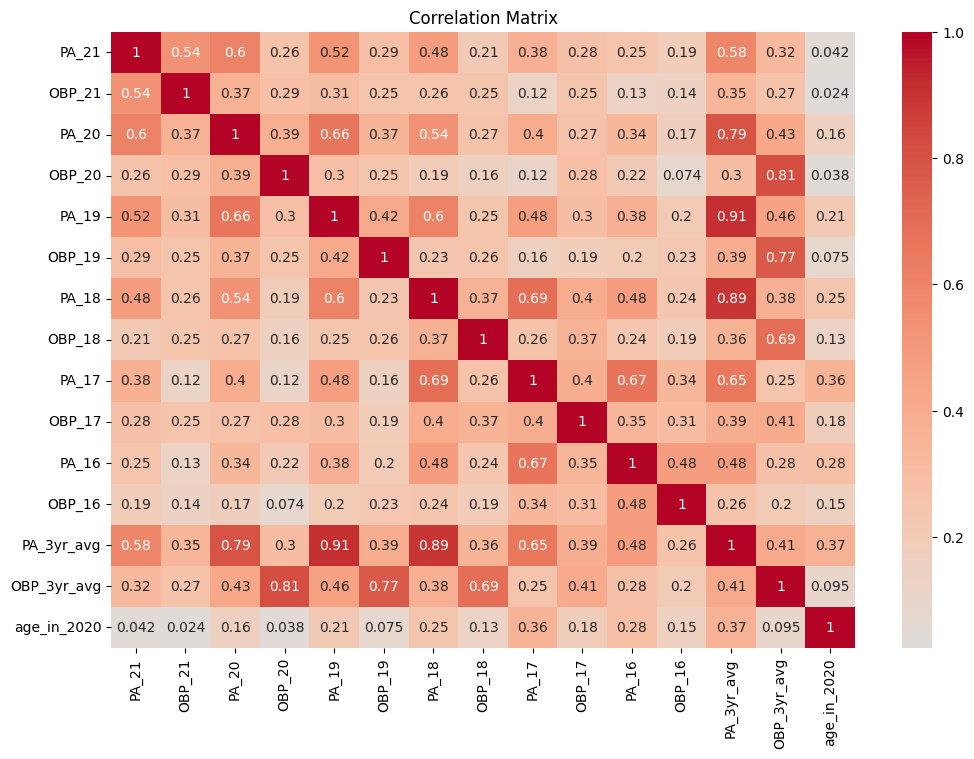

In [ ]:
key_variables=['PA_21', 'OBP_21', 'PA_20', 'OBP_20',
       'PA_19', 'OBP_19', 'PA_18', 'OBP_18', 'PA_17', 'OBP_17', 'PA_16',
       'OBP_16', 'PA_3yr_avg', 'OBP_3yr_avg', 'age_in_2020']

plt.figure(figsize=(12, 8))
corr_matrix = datamodeling[key_variables].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

Age seems less correlated with OBP21 but with PA

## Modeling

Goal: Predict each player’s on-base percentage in the 2021 season given his plate appearances and on-base percentages in prior seasons.

### **Procedure**

PROCEDURE: In this modeling I explore different approaches.

* 1) The linear regression seems a good approach in general, as fits well Mean Squared Error: 0.002 but still the r2 is low explaining low of the variance
R^2 Score: 0.18
* 2) Proceed with the descriptive phase. I plot the histograms to check out if the data is skewed of if it shows extreme values in PA and OBP per year. I later explore the correlations of the variables. From this, looks like PA from previous years is more correlated to OBP 21 (and respectives 19,18, etc). It also looks a linear relationship with OBP. It will be important to keep this variable.
* 3) Treating missings is a critical step. I evaluated the inputation but the data distributios is very sensitive to this because we are predicting per player. So then I decided to proceed on the creation of new variables as moving averages on time windows for 1y, 2y, 3y, etc respectively from 2020 and explore the correlation of the new variables against the ones identified previously as good predictors.

#### Libraries

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

##### Features correlation

In [ ]:
features=key_variables
features

['PA_3yr_avg', 'OBP_3yr_avg', 'age_in_2020']

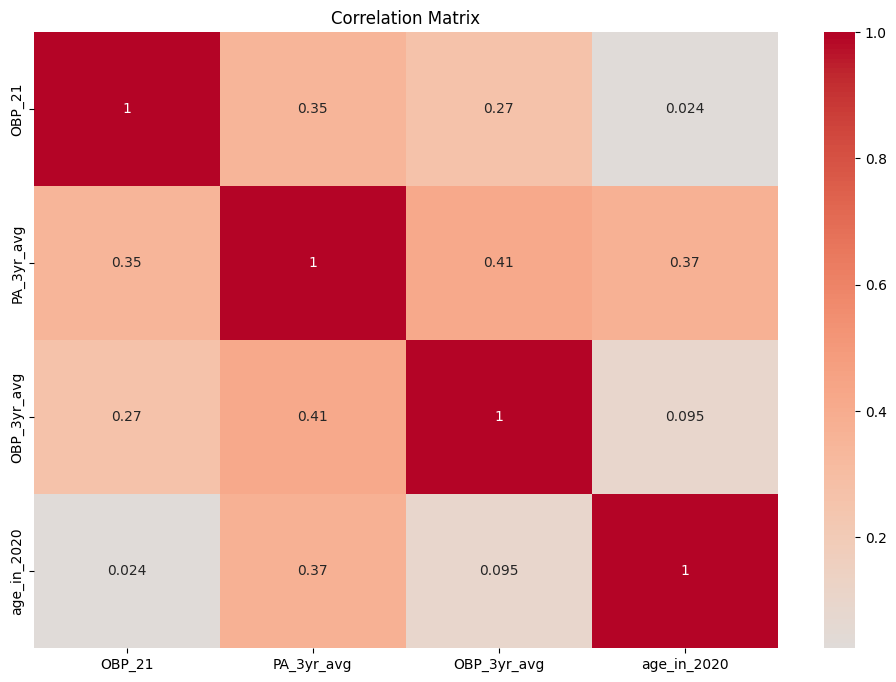

In [ ]:
# Plotting correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = df[['OBP_21','PA_3yr_avg', 'OBP_3yr_avg', 'age_in_2020']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

### Linear Regression

In [237]:
key_variables=['PA_3yr_avg', 'OBP_3yr_avg', 'age_in_2020']

In [252]:
features = key_variables
target = 'OBP_21'

df = datamodeling
X = df[features]
y = df[target]



##### Fitting the model

In [248]:
# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the linear regression model using statsmodels
model = sm.OLS(y_train, X_train).fit()

# Get the model summary, including p-values
summary = model.summary()
print(summary)

# To get the coefficients and p-values separately
coefficients = model.params
p_values = model.pvalues

print("Coefficients:")
print(coefficients)
print("\nP-values:")
print(p_values)


                            OLS Regression Results                            
Dep. Variable:                 OBP_21   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     19.83
Date:                Sun, 23 Jun 2024   Prob (F-statistic):           5.32e-12
Time:                        21:28:52   Log-Likelihood:                 688.25
No. Observations:                 404   AIC:                            -1368.
Df Residuals:                     400   BIC:                            -1352.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2947      0.022     13.695      

##### Coefficients interpretation

**Coefficients Interpretation**
* Intercept (const):

Coefficient: 0.2947 with a standard error of 0.022. This suggests that if all predictor variables are zero, OBP_21 is expected to be 0.2947. The t-statistic and corresponding p-value indicate that the intercept is statistically significant.
* PA_3yr_avg:

Coefficient: 0.00009227. This means that for each additional Plate Appearance (on average over the past three years), OBP_21 increases by 0.00009227, holding other variables constant. The statistical significance is strong (p < 0.001), indicating a reliable predictor.
* OBP_3yr_avg:

Coefficient: 0.0955. This indicates that for each one-unit increase in OBP_3yr_avg, OBP_21 is expected to increase by 0.0955. It's statistically significant (p = 0.018), showing a positive and significant impact on OBP_21.
* age_in_2020:

Coefficient: -0.001350. This suggests that each additional year of age is associated with a decrease in OBP_21 by 0.001350. This coefficient is statistically significant at the 5% level (p = 0.047), indicating that age has a slight negative effect on OBP_21.

##### Metrics of the model performance

In [249]:
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Display the first few predictions
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions.head()

Mean Squared Error: 0.002547240072598733
R^2 Score: 0.18026091991105675


,Actual,Predicted
190,0.341,0.296435
296,0.315,0.296661
553,0.194,0.278557
76,0.368,0.307626
500,0.281,0.299809


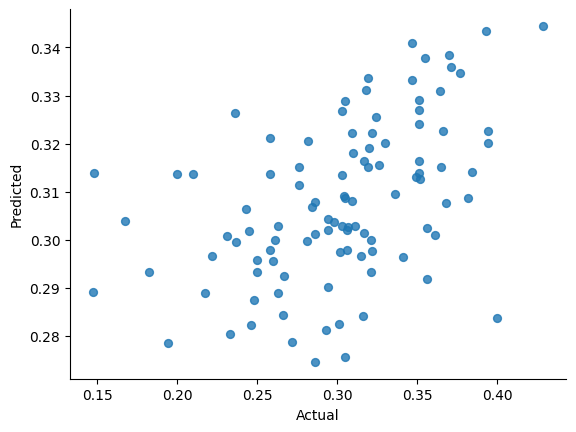

In [250]:
from matplotlib import pyplot as plt

# Display the first few predictions
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

predictions.plot(kind='scatter', x='Actual', y='Predicted', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Good fit but low variance explained

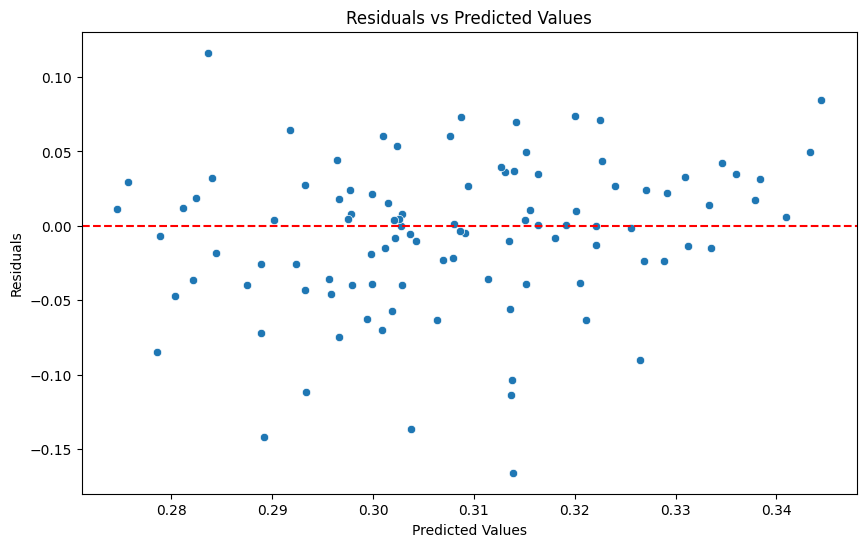

In [251]:

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate residuals and plot them
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()


##### CONCLUSION

From diagnosing the fit of the regression model, where a random scatter of residuals around zero suggests a good fit we can conclude we have a good model in general but room for improvement as not all the variables are linearly correlated

### Random Forest

Random Forest Regression is adecuate because it does not lie in the assumption of linearity.

**Robustness to Overfitting:**
Although individual trees in a Random Forest may overfit to the data, the ensemble approach in which the final prediction is made based on the average of all trees helps to reduce this risk significantly. This aggregation (also known as bagging) helps improve the model’s generalization capabilities.

**Feature Importance:**
Random Forest provides useful insights regarding which features are most influential in predicting the outcome. This is done through calculating the decrease in node impurity weighted by the probability of reaching that node (for classification) or the decrease in variance (for regression). This feature importance metric helps in understanding the data better and in feature selection for improving model performance.

#### PROCEDURE

* 1. I consider the features described below as the predictive variables. Those variables respond on remporality as they represent the data before 2021. OBP_21 is the outcome variable to predict.
* 2. I separate the set into train and test, for features and outcome label
* 3. I Trained a Random Forest model with hyperparameter tuning to select the best model
* 4. For business decision making, I provide the feature importance given by the RFR model. Explaining the meaning in the context of the target variable and beisbal data.
* 5. I print also the model performance metrics.

In [108]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

##### Settings

In [133]:
datamodeling=pd.read_parquet('/content/drive/MyDrive/USA/PHILLIES-beisbal/obp_2.parquet')

In [138]:
#['OBP_3yr_avg', 'age_in_2020', 'PA_3yr_avg', 'maxEV_3yr_avg']
datamodeling.columns

Index(['Name', 'playerid', 'birth_date', 'PA_21', 'OBP_21', 'PA_20', 'OBP_20',
       'PA_19', 'OBP_19', 'PA_18', 'OBP_18', 'PA_17', 'OBP_17', 'PA_16',
       'OBP_16', 'PA_1yr_avg', 'PA_2yr_avg', 'PA_3yr_avg', 'PA_4yr_avg',
       'PA_5yr_avg', 'OBP_1yr_avg', 'OBP_2yr_avg', 'OBP_3yr_avg',
       'OBP_4yr_avg', 'OBP_5yr_avg', 'age_in_2016', 'age_in_2017',
       'age_in_2018', 'age_in_2019', 'age_in_2020', 'age_in_2021'],
      dtype='object')

In [140]:
target = 'OBP_21'
f=['PA_3yr_avg', 'age_in_2020', 'OBP_3yr_avg']
df = datamodeling
X = df[f]
y = df[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [141]:
# Split the set

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#### Fitting the model

In [142]:
# Train a Random Forest model with hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_



In [143]:
import pickle
# Save the model to a file
with open('/content/drive/MyDrive/USA/PHILLIES-beisbal/random_forest_model.pkl', 'wb') as file:
    pickle.dump(model, file)


#### Variable importance

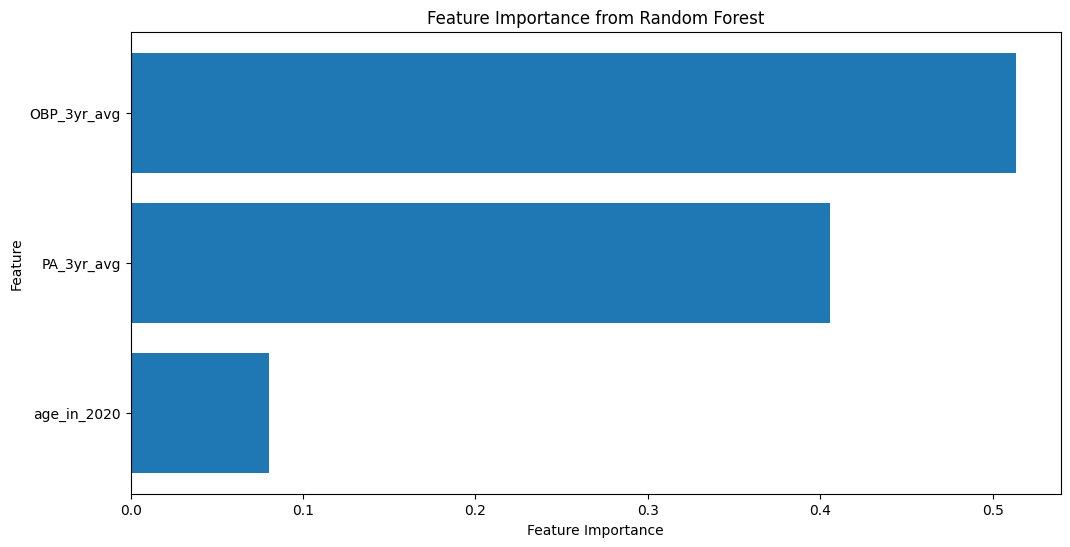

,Feature,Importance
1,OBP_3yr_avg,0.513738
0,PA_3yr_avg,0.405807
2,age_in_2020,0.080455


In [233]:
import matplotlib.pyplot as plt

# Get feature importances
importances = best_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

importance_df


#### RF model evaluation

Best hyperparameters: {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
Best R² score during training: 0.10592474723030487
Training R²: 0.3142251987924646
Training RMSE: 0.03909317915988392
Training MAE: 0.03005999796708355
Test R²: 0.21915491333751058
Test RMSE: 0.04925831595674495
Test MAE: 0.03742105161734404


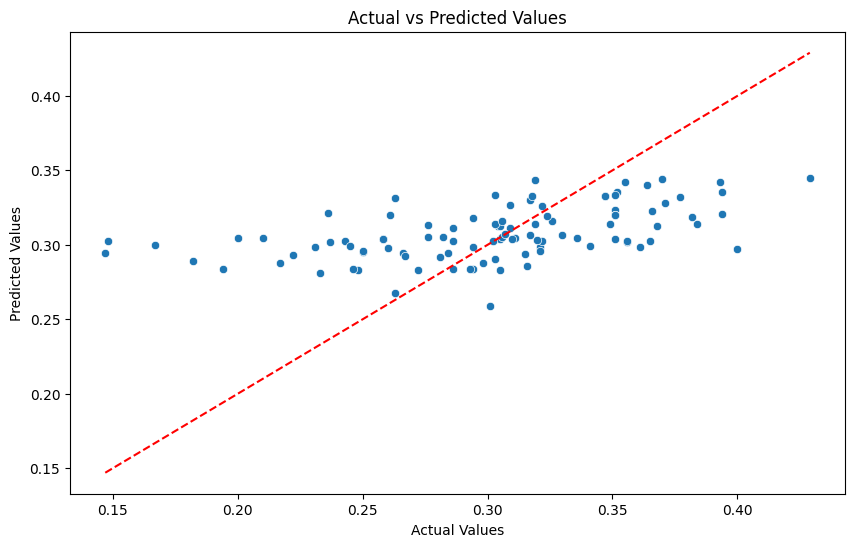

In [234]:
# Print the best hyperparameters and R2 score
print("Best hyperparameters:", grid_search.best_params_)
print("Best R² score during training:", grid_search.best_score_)

# Evaluate the model on the training set
y_train_pred = best_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)
print("Training R²:", train_r2)
print("Training RMSE:", train_rmse)
print("Training MAE:", train_mae)

# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)
print("Test R²:", test_r2)
print("Test RMSE:", test_rmse)
print("Test MAE:", test_mae)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, marker='o')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()


#### CONCLUSION

**Explanation of Each Feature's Importance**

* OBP_3yr_avg (Importance: 0.513738)

Description: This feature represents the average On-Base Percentage for the previous three years, from 2018 to 2020. It aggregates the player's performance in terms of getting on base over a significant period, smoothing out any single-year anomalies.
Why It's Important: This is the most influential variable in your model with an importance score of about 51.37%. The high importance of this variable suggests that past consistency in a player's ability to get on base is a strong predictor of future performance. It implies that players who have historically managed to maintain a higher OBP are likely to continue doing so, making it a reliable metric for forecasting future OBP.
* PA_3yr_avg (Importance: 0.405807)

Description: This feature calculates the average number of Plate Appearances over the past three years (2018-2020). Plate Appearances are a count of every time a player comes to bat, except for certain infrequent situations.
Why It's Important: With an importance score of about 40.58%, this variable is also a critical predictor in your model. The rationale here is that the more opportunities a player has at bat, the more likely they are to refine and demonstrate their batting skills, including drawing walks and choosing good pitches, which directly influences their OBP. A higher average PA suggests more experience and possibly more skill in handling different pitching situations.
* age_in_2020 (Importance: 0.080455)

Description: This feature represents the age of the player in the year 2020. Age can be a significant factor in sports analytics as it often correlates with physical and cognitive maturity as well as experience in the sport.
Why It's Important: Although less significant than the other variables, with an importance score of about 8.04%, the player's age still plays a role in predicting OBP. Younger players may still be developing their skills and could show rapid improvement, whereas older players might have more consistency but could also potentially be past their peak performance years. The impact of age could also relate to factors like stamina, speed, and reaction time, which indirectly affect a player’s ability to get on base.

**Summary of the Model's Logic**
Overall Model Insight: The model strongly prioritizes historical performance metrics (OBP and PA averages over the last three years) over demographic factors (age). This prioritization suggests that a player's recent history in the game is a more reliable indicator of their future performance than age alone.

### Gradint Boosting approach and ensemble methods

Takeover --- good predictions but explains few of the variance of underlying data again, the RF perform better than LR in general

In [235]:
from sklearn.ensemble import GradientBoostingRegressor

# Train a Gradient Boosting model with hyperparameter tuning
param_grid_gbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}
grid_search_gbm = GridSearchCV(GradientBoostingRegressor(), param_grid_gbm, cv=5, scoring='r2', n_jobs=-1)
grid_search_gbm.fit(X_train, y_train)

# Best model
best_gbm = grid_search_gbm.best_estimator_

# Make predictions
y_pred_gbm = best_gbm.predict(X_test)

# Evaluate the model
mse_gbm = mean_squared_error(y_test, y_pred_gbm)
r2_gbm = r2_score(y_test, y_pred_gbm)

print(f"Best Parameters (GBM): {grid_search_gbm.best_params_}")
print(f"Mean Squared Error (GBM): {mse_gbm}")
print(f"R^2 Score (GBM): {r2_gbm}")

# Display the first few predictions
predictions_gbm = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_gbm})
predictions_gbm.head()


Best Parameters (GBM): {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error (GBM): 0.002591926613346427
R^2 Score (GBM): 0.16588013806056567


,Actual,Predicted
190,0.341,0.299627
296,0.315,0.308885
553,0.194,0.292410
76,0.368,0.310022
500,0.281,0.300937


In [236]:
from sklearn.ensemble import StackingRegressor

# Define base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=30, min_samples_split=5)),
    ('gbm', GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, min_samples_split=2))
]

# Define meta-model
meta_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)

# Create the stacking model
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Make predictions
y_pred_stack = stacking_model.predict(X_test)

# Evaluate the model
mse_stack = mean_squared_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)

print(f"Mean Squared Error (Stacking): {mse_stack}")
print(f"R^2 Score (Stacking): {r2_stack}")

# Display the first few predictions
predictions_stack = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_stack})
predictions_stack.head()


Mean Squared Error (Stacking): 0.0027383310970517604
R^2 Score (Stacking): 0.11876503568583452


,Actual,Predicted
190,0.341,0.255103
296,0.315,0.272500
553,0.194,0.294634
76,0.368,0.313162
500,0.281,0.310564


This approach does not outperforms the RF or LR ones. I keep it for informative purposes but not to take any decision.

## PLOTS

RF seems the reliable model to proceed with based on the conclusions in the respecitve cell.

In [253]:
X_sample = datamodeling[features]

In [254]:
# Calling the model best?mdoel
predictions = best_model.predict(X_sample)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


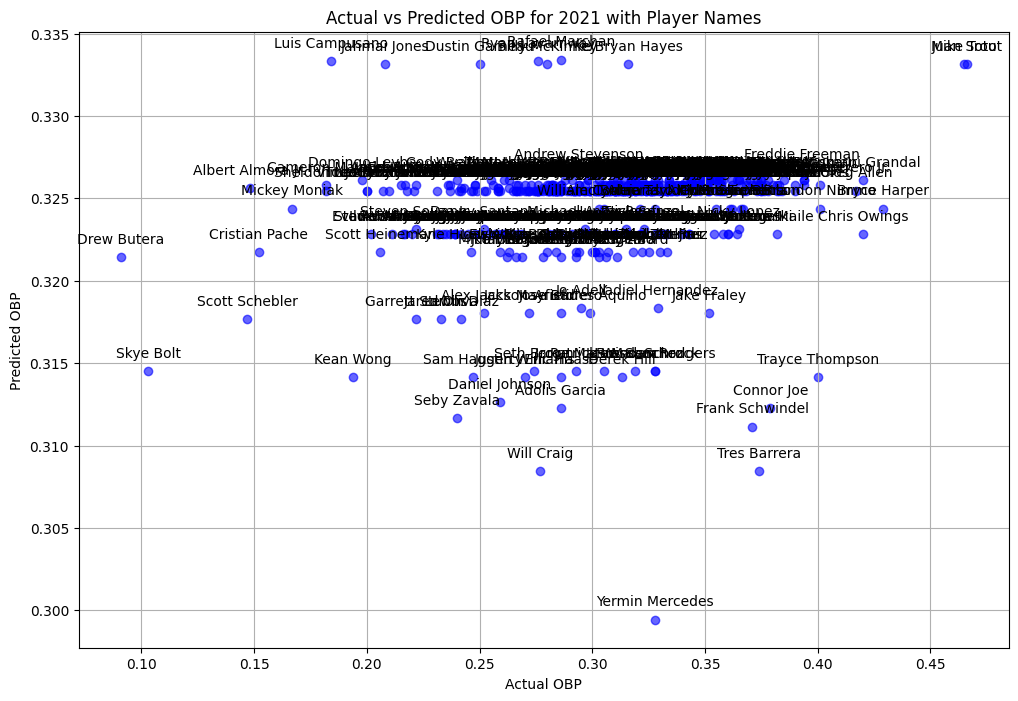

In [262]:
results_df = pd.DataFrame({
    'Actual OBP': datamodeling[target].values,
    'Predicted OBP': predictions,
    'Player Name': datamodeling['Name'].values
})

plt.figure(figsize=(12, 8))
plt.scatter(results_df['Actual OBP'], results_df['Predicted OBP'], color='blue', alpha=0.6)

# Annotating each point with the player's name
for idx, row in results_df.iterrows():
    plt.annotate(row['Player Name'], (row['Actual OBP'], row['Predicted OBP']), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Actual OBP')
plt.ylabel('Predicted OBP')
plt.title('Actual vs Predicted OBP for 2021 with Player Names')
plt.grid(True)
plt.show()

In [268]:
results_df

,Actual OBP,Predicted OBP,Player Name
0,0.400,0.314134,Trayce Thompson
1,0.466,0.333139,Mike Trout
2,0.429,0.324379,Bryce Harper
3,0.420,0.322836,Chris Owings
4,0.465,0.333139,Juan Soto
...,...,...,...
501,0.148,0.325616,Albert Almora Jr.
502,0.184,0.333333,Luis Campusano
503,0.182,0.325803,Cameron Maybin
504,0.103,0.314514,Skye Bolt


from matplotlib import pyplot as plt
results_df['Actual OBP'].plot(kind='hist', bins=20, title='Actual OBP')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['Predicted OBP'].plot(kind='hist', bins=20, title='Predicted OBP')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='Actual OBP', y='Predicted OBP', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['Actual OBP'].plot(kind='line', figsize=(8, 4), title='Actual OBP')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['Predicted OBP'].plot(kind='line', figsize=(8, 4), title='Predicted OBP')
plt.gca().spines[['top', 'right']].set_visible(False)

# More data into our analysis

I explored more data sources to  feed the predictive modeling. I did not have chance to retrieve more data from those but I will let here the steps I took to revise this data as it seems promising for future inferences.

## Documentation
I will use the library pybaseball from https://pypi.org/project/pybaseball/2.0.0/ to retrieve information from players. Here is an example of the input and output. I will use mainly mlb_played_first	mlb_played_last the years at wich the player mades its debut in mlb. For Clayton Kershaw player, the year of debut is 2008, which means that for 2020 it has 12 years as professional, i will call this variable seniority.





In [ ]:
from pybaseball import  playerid_lookup
from pybaseball import  statcast_pitcher
a=playerid_lookup('kershaw', 'clayton')
a

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,kershaw,clayton,477132,kersc001,kershcl01,2036,2008.0,2023.0


In [ ]:
# This is the code to store the data

df = data[["Name","playerid"]]

def playerid_lookup_function(pid, first_name, last_name):
    print(first_name, last_name)
    a=playerid_lookup(str(last_name.lower()), str(first_name.lower()))
    try:
      return {
          'playerid': pid,
          'name': first_name+' '+last_name,
          'key_bbref': a['key_bbref'].values[0],
          'key_fangraphs': a['key_fangraphs'].values[0],
          'key_mlbam': a['key_mlbam'].values[0],
          'key_retro': a['key_retro'].values[0],
          'mlb_played_first': a['mlb_played_first'].values[0],
          'mlb_played_last': a['mlb_played_last'].values[0]
      }
    except:
      return {
          'playerid': pid,
          'name': first_name+' '+last_name,
          'key_bbref': '11',
          'key_fangraphs': '11',
          'key_mlbam': '11',
          'key_retro': '11',
          'mlb_played_first': '11',
          'mlb_played_last': '11'
      }

# Initialize empty lists to store new data
positions = []


# Iterate through the dataframe and fetch additional data
for index, row in df.iterrows():
    name_parts = row['Name'].split()
    first_name = name_parts[0]
    last_name = name_parts[1]

    player_data = playerid_lookup_function(row['playerid'], first_name, last_name)

    # Append the fetched data to the lists
    positions.append(player_data)


Trayce Thompson
Mike Trout
Bryce Harper
Chris Owings
Nick Fortes
Juan Soto
Vladimir Guerrero
Byron Buxton
Ronald Acuna
Brandon Belt
Jesse Winker
Frank Schwindel
Fernando Tatis
Yasmani Grandal
Jose Siri
Luis Robert
Shohei Ohtani
Kyle Schwarber
Joey Votto
Nick Castellanos
Corey Seager
Aaron Judge
Trea Turner
Bryan Reynolds
Ketel Marte
Darin Ruf
John Hicks
Tyler O'Neill
C.J. Cron
Kyle Tucker
George Springer
Austin Riley
Freddie Freeman
Buster Posey
Max Muncy
Matt Olson
Brandon Crawford
Greg Allen
A.J. Pollock
Paul Goldschmidt
Rafael Devers
Jose Ramirez
Cedric Mullins
Mitch Garver
Giancarlo Stanton
Yordan Alvarez
Brandon Nimmo
Teoscar Hernandez
Xander Bogaerts
Marcus Semien
Garrett Cooper
Connor Joe
Mookie Betts
Rhys Hoskins
Starling Marte
J.D. Martinez
Will Smith
Carlos Correa
Brandon Lowe
Yuli Gurriel
Jonathan India
Pete Alonso
Salvador Perez
Mike Zunino
Justin Turner
Luke Maile
J.D. Davis
Jared Walsh
Jose Altuve
Kris Bryant
Matt Vierling
Rafael Ortega
Adam Engel
Franmil Reyes
Jose Abreu

In [ ]:
original = data[["Name","playerid"]]
len(original)

572

In [ ]:
positions

[{'playerid': 9952,
  'name': 'Trayce Thompson',
  'key_bbref': 'thomptr01',
  'key_fangraphs': 9952,
  'key_mlbam': 572204,
  'key_retro': 'thomt002',
  'mlb_played_first': 2015.0,
  'mlb_played_last': 2023.0},
 {'playerid': 10155,
  'name': 'Mike Trout',
  'key_bbref': 'troutmi01',
  'key_fangraphs': 10155,
  'key_mlbam': 545361,
  'key_retro': 'troum001',
  'mlb_played_first': 2011.0,
  'mlb_played_last': 2024.0},
 {'playerid': 11579,
  'name': 'Bryce Harper',
  'key_bbref': 'harpebr03',
  'key_fangraphs': 11579,
  'key_mlbam': 547180,
  'key_retro': 'harpb003',
  'mlb_played_first': 2012.0,
  'mlb_played_last': 2024.0},
 {'playerid': 10030,
  'name': 'Chris Owings',
  'key_bbref': 'owingch01',
  'key_fangraphs': 10030,
  'key_mlbam': 572008,
  'key_retro': 'owinc001',
  'mlb_played_first': 2013.0,
  'mlb_played_last': 2023.0},
 {'playerid': 21538,
  'name': 'Nick Fortes',
  'key_bbref': 'forteni01',
  'key_fangraphs': 21538,
  'key_mlbam': 663743,
  'key_retro': 'fortn001',
  'mlb_

In [ ]:
df = pd.DataFrame(positions)
df

,playerid,name,key_bbref,key_fangraphs,key_mlbam,key_retro,mlb_played_first,mlb_played_last
0,9952,Trayce Thompson,thomptr01,9952,572204,thomt002,2015.0,2023.0
1,10155,Mike Trout,troutmi01,10155,545361,troum001,2011.0,2024.0
2,11579,Bryce Harper,harpebr03,11579,547180,harpb003,2012.0,2024.0
3,10030,Chris Owings,owingch01,10030,572008,owinc001,2013.0,2023.0
4,21538,Nick Fortes,forteni01,21538,663743,fortn001,2021.0,2024.0
...,...,...,...,...,...,...,...,...
567,19872,Greg Deichmann,deichgr01,19872,656364,deicg001,2021.0,2021.0
568,5223,Cameron Maybin,maybica01,5223,457727,maybc001,2007.0,2021.0
569,18881,Curtis Terry,terrycu01,18881,663799,terrc001,2021.0,2021.0
570,17723,Skye Bolt,boltsk01,17723,621450,bolts001,2019.0,2022.0


In [ ]:
# Mergin with my data

data_merged = original.merge(df, on='playerid')
data_merged

,Name,playerid,name,key_bbref,key_fangraphs,key_mlbam,key_retro,mlb_played_first,mlb_played_last
0,Trayce Thompson,9952,Trayce Thompson,thomptr01,9952,572204,thomt002,2015.0,2023.0
1,Mike Trout,10155,Mike Trout,troutmi01,10155,545361,troum001,2011.0,2024.0
2,Bryce Harper,11579,Bryce Harper,harpebr03,11579,547180,harpb003,2012.0,2024.0
3,Chris Owings,10030,Chris Owings,owingch01,10030,572008,owinc001,2013.0,2023.0
4,Nick Fortes,21538,Nick Fortes,forteni01,21538,663743,fortn001,2021.0,2024.0
...,...,...,...,...,...,...,...,...,...
567,Greg Deichmann,19872,Greg Deichmann,deichgr01,19872,656364,deicg001,2021.0,2021.0
568,Cameron Maybin,5223,Cameron Maybin,maybica01,5223,457727,maybc001,2007.0,2021.0
569,Curtis Terry,18881,Curtis Terry,terrycu01,18881,663799,terrc001,2021.0,2021.0
570,Skye Bolt,17723,Skye Bolt,boltsk01,17723,621450,bolts001,2019.0,2022.0


In [ ]:
#saving the output
data_merged.to_csv('/content/drive/MyDrive/USA/PHILLIES-beisbal/fan_graphs.csv', index=False)

In [76]:
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              572 non-null    object 
 1   playerid          572 non-null    int64  
 2   name              572 non-null    object 
 3   key_bbref         572 non-null    object 
 4   key_fangraphs     572 non-null    int64  
 5   key_mlbam         572 non-null    int64  
 6   key_retro         572 non-null    object 
 7   mlb_played_first  572 non-null    float64
 8   mlb_played_last   572 non-null    float64
dtypes: float64(2), int64(3), object(4)
memory usage: 40.3+ KB


### Getting the data and merging with our data for analysis

In [37]:
data_merged=pd.read_csv('/content/drive/MyDrive/USA/PHILLIES-beisbal/fan_graphs.csv')
data_merged

,Name,playerid,name,key_bbref,key_fangraphs,key_mlbam,key_retro,mlb_played_first,mlb_played_last
0,Trayce Thompson,9952,Trayce Thompson,thomptr01,9952,572204,thomt002,2015.0,2023.0
1,Mike Trout,10155,Mike Trout,troutmi01,10155,545361,troum001,2011.0,2024.0
2,Bryce Harper,11579,Bryce Harper,harpebr03,11579,547180,harpb003,2012.0,2024.0
3,Chris Owings,10030,Chris Owings,owingch01,10030,572008,owinc001,2013.0,2023.0
4,Nick Fortes,21538,Nick Fortes,forteni01,21538,663743,fortn001,2021.0,2024.0
...,...,...,...,...,...,...,...,...,...
567,Greg Deichmann,19872,Greg Deichmann,deichgr01,19872,656364,deicg001,2021.0,2021.0
568,Cameron Maybin,5223,Cameron Maybin,maybica01,5223,457727,maybc001,2007.0,2021.0
569,Curtis Terry,18881,Curtis Terry,terrycu01,18881,663799,terrc001,2021.0,2021.0
570,Skye Bolt,17723,Skye Bolt,boltsk01,17723,621450,bolts001,2019.0,2022.0


In [67]:
data_analysis=pd.read_parquet('/content/drive/MyDrive/USA/PHILLIES-beisbal/obp_2.parquet')

#### Create seniority variable



Variable seniority is the number of years as profesional mlb player to 2020

In [10]:
data_merged.columns

Index(['Name', 'playerid', 'name', 'key_bbref', 'key_fangraphs', 'key_mlbam',
       'key_retro', 'mlb_played_first', 'mlb_played_last'],
      dtype='object')

In [68]:
data2=data_analysis.merge(data_merged[['playerid', 'key_bbref', 'key_fangraphs', 'key_mlbam',
       'key_retro', 'mlb_played_first', 'mlb_played_last']], on='playerid', how='inner')
data2['seniority']=2020-a['mlb_played_first']
data2.head(5)

,Name,playerid,birth_date,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,...,age_in_2019,age_in_2020,age_in_2021,key_bbref,key_fangraphs,key_mlbam,key_retro,mlb_played_first,mlb_played_last,seniority
0,Trayce Thompson,9952,1991-03-15,35,0.400,NaN,NaN,NaN,NaN,137.0,...,28,29,30,thomptr01,9952,572204,thomt002,2015.0,2023.0,5.0
1,Mike Trout,10155,1991-08-07,146,0.466,241.0,0.390,600.0,0.438,608.0,...,28,29,30,troutmi01,10155,545361,troum001,2011.0,2024.0,9.0
2,Bryce Harper,11579,1992-10-16,599,0.429,244.0,0.420,682.0,0.372,695.0,...,27,28,29,harpebr03,11579,547180,harpb003,2012.0,2024.0,8.0
3,Chris Owings,10030,1991-08-12,50,0.420,44.0,0.318,196.0,0.209,309.0,...,28,29,30,owingch01,10030,572008,owinc001,2013.0,2023.0,7.0
4,Juan Soto,20123,1998-10-25,654,0.465,196.0,0.490,659.0,0.401,494.0,...,21,22,23,sotoju01,20123,665742,sotoj001,2018.0,2024.0,2.0


In [77]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 38 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Name              506 non-null    object        
 1   playerid          506 non-null    int64         
 2   birth_date        506 non-null    datetime64[ns]
 3   PA_21             506 non-null    int64         
 4   OBP_21            506 non-null    float64       
 5   PA_20             466 non-null    float64       
 6   OBP_20            466 non-null    float64       
 7   PA_19             437 non-null    float64       
 8   OBP_19            437 non-null    float64       
 9   PA_18             359 non-null    float64       
 10  OBP_18            359 non-null    float64       
 11  PA_17             298 non-null    float64       
 12  OBP_17            298 non-null    float64       
 13  PA_16             247 non-null    float64       
 14  OBP_16            247 non-

### Batting stats

I will use not pybaseball library to retrieve more data from palyers https://pypi.org/project/pybaseball/ i can then retrieve stats per player on an historical fasion

In [14]:
pip install pybaseball

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.3.0
    Uninstalling PyJWT-2.3.0:
      Successfully uninstalled PyJWT-2.3.0


In [41]:
from pybaseball import batting_stats
import numpy as np
import pandas as pd
import os

START=2016
END=2021

In [18]:
if os.path.exists("batting.csv"):
    batting = pd.read_csv("batting.csv", index_col=0)
else:
    batting = batting_stats(START, END, qual=200)
    batting.to_csv("batting.csv")

In [20]:
batting

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR
1,13611,2018,Mookie Betts,BOS,25,136,520,614,180,96,...,110.6,217,0.500,434,0.220,0.270,NaN,NaN,NaN,10.4
2,10155,2018,Mike Trout,LAA,26,140,471,608,147,80,...,118.0,162,0.460,352,0.201,0.261,NaN,NaN,NaN,9.5
10,15640,2017,Aaron Judge,NYY,25,155,542,678,154,75,...,121.1,186,0.550,338,0.157,0.290,NaN,NaN,NaN,8.7
21,10155,2016,Mike Trout,LAA,24,159,549,681,173,107,...,117.1,167,0.400,417,0.188,0.259,NaN,NaN,NaN,8.7
20,17678,2019,Alex Bregman,HOU,25,156,554,690,164,84,...,107.4,178,0.372,479,0.204,0.250,NaN,NaN,NaN,8.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704,4613,2016,Prince Fielder,TEX,32,89,326,370,69,45,...,113.0,85,0.317,268,0.161,0.265,NaN,NaN,NaN,-1.9
1887,746,2016,A.J. Pierzynski,ATL,39,81,247,259,54,37,...,106.8,75,0.339,221,0.116,0.217,NaN,NaN,NaN,-1.7
1826,3179,2016,Dioner Navarro,- - -,32,101,304,334,63,42,...,104.3,52,0.218,238,0.187,0.287,NaN,NaN,NaN,-1.8
1902,3448,2019,Jeff Mathis,TEX,36,88,228,244,36,25,...,105.5,37,0.261,142,0.155,0.322,NaN,NaN,NaN,-2.1


In [42]:
batting.columns

Index(['IDfg', 'Season', 'Name', 'Team', 'Age', 'G', 'AB', 'PA', 'H', '1B',
       ...
       'maxEV', 'HardHit', 'HardHit%', 'Events', 'CStr%', 'CSW%', 'xBA',
       'xSLG', 'xwOBA', 'L-WAR'],
      dtype='object', length=320)

**NEW VARIABLES**
I will get historical data on the last 3 years previous to 2020, including 2020.
1. maxEV (Maximum Exit Velocity)
Explanation: maxEV refers to the highest speed at which a ball is hit by a player over a certain period, typically measured in miles per hour (mph). This metric indicates the peak power a player can generate when making contact with the ball.
Relation to OBP: While maxEV itself doesn't directly determine OBP, it indicates the quality of contact. Players who consistently achieve higher exit velocities are likely to produce harder-hit balls, which can lead to more base hits, thus potentially increasing their OBP. Harder hits are less likely to be fielded out, increasing the likelihood of reaching base.
2. xwOBA (Expected Weighted On-Base Average)
Explanation: xwOBA is an advanced metric derived from exit velocity, launch angle, and, on certain types of batted balls, sprint speed. It is intended to remove outcomes from the equation and focus purely on a player's contact quality and discipline at the plate.
Relation to OBP: xwOBA is highly correlated with OBP because it includes walks, hit by pitches, and the quality of batted balls (excluding the actual outcomes of plays). A higher xwOBA suggests a player is good at getting on base through both hitting and plate discipline, making it a direct and potent predictor for OBP.
3. L-WAR (Wins Above Replacement for League)
Explanation: WAR (Wins Above Replacement) measures a player's total contributions to their team in all facets of the game. It encompasses offensive skills, defensive skills, base running, and the context of the league and position played.
Relation to OBP: Although WAR includes a broad array of skills beyond just getting on base, a high offensive component within WAR could correlate with high OBP, as offensive value includes batting performance. Players who contribute significantly to their team's wins are often effective at reaching base, among other skills.
4. HardHit% (Hard-Hit Percentage)
Explanation: HardHit% represents the percentage of batted balls that are hit with a high exit velocity (typically defined as balls hit at 95 mph or higher).
Relation to OBP: Similar to maxEV, a higher HardHit% indicates better quality of contact. Players who hit the ball harder are more likely to get hits, potentially increasing their OBP. Hard hits are more challenging for fielders to handle, thus improving the chances of reaching base.
5. CSW% (Called Strikes Plus Whiffs Percentage)
Explanation: CSW% is the sum of called strikes and swinging strikes divided by total pitches. This metric is used to evaluate a pitcher’s effectiveness but can be inverted to assess a hitter's ability to avoid unproductive outcomes at the plate.
Relation to OBP: For batters, a lower CSW% means fewer strikes called and fewer swings-and-misses, indicating better pitch selection and contact skills. Good plate discipline, reflected by lower CSW%, can lead to more walks and fewer strikeouts, positively affecting a player's OBP.

In [121]:
batting_g=batting.groupby('Name', group_keys=False).filter(lambda x:x.shape[0] > 1)
batting_g_20 = batting_g[batting_g['Season'] == 2020]
batting_g_20.rename(columns={"maxEV":"maxEV_20","xwOBA":"xwOBA_20","L-WAR":"L-WAR_20", 'HardHit%':'HardHit%_20','CSW%':'CSW%_20'}, inplace=True)

batting_g_20.head(5)

<ipython-input-121-14f4348a572c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting_g_20.rename(columns={"maxEV":"maxEV_20","xwOBA":"xwOBA_20","L-WAR":"L-WAR_20", 'HardHit%':'HardHit%_20','CSW%':'CSW%_20'}, inplace=True)


,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,maxEV_20,HardHit,HardHit%_20,Events,CStr%,CSW%_20,xBA,xSLG,xwOBA_20,L-WAR_20
80,19709,2020,Fernando Tatis Jr.,SDP,21,59,224,257,62,32,...,113.4,102,0.622,164,0.144,0.269,NaN,NaN,NaN,3.3
26,13510,2020,Jose Ramirez,CLE,27,58,219,254,64,30,...,114.3,62,0.350,177,0.170,0.229,NaN,NaN,NaN,3.2
0,5361,2020,Freddie Freeman,ATL,30,60,214,262,73,36,...,109.3,96,0.542,177,0.104,0.191,NaN,NaN,NaN,3.2
34,15676,2020,Jose Abreu,CHW,33,60,240,262,76,42,...,114.0,97,0.533,182,0.155,0.293,NaN,NaN,NaN,2.9
31,16252,2020,Trea Turner,WSN,27,59,233,259,78,47,...,111.2,81,0.407,199,0.172,0.260,NaN,NaN,NaN,2.7


In [120]:
batting_g_19 = batting_g[batting_g['Season'] == 2019]
batting_g_19.rename(columns={"maxEV":"maxEV_19","xwOBA":"xwOBA_19","L-WAR":"L-WAR_19", 'HardHit%':'HardHit%_19',
                             'CSW%':'CSW%_19'}, inplace=True)

batting_g_19.head(5)

<ipython-input-120-b3ccc42b4e99>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting_g_19.rename(columns={"maxEV":"maxEV_19","xwOBA":"xwOBA_19","L-WAR":"L-WAR_19", 'HardHit%':'HardHit%_19',


,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,maxEV_19,HardHit,HardHit%_19,Events,CStr%,CSW%_19,xBA,xSLG,xwOBA_19,L-WAR_19
20,17678,2019,Alex Bregman,HOU,25,156,554,690,164,84,...,107.4,178,0.372,479,0.204,0.250,NaN,NaN,NaN,8.2
25,15998,2019,Cody Bellinger,LAD,23,156,558,660,170,86,...,110.6,207,0.456,454,0.149,0.246,NaN,NaN,NaN,7.8
6,10155,2019,Mike Trout,LAA,27,134,470,600,137,63,...,116.6,155,0.438,354,0.193,0.258,NaN,NaN,NaN,8.4
30,12861,2019,Anthony Rendon,WSN,29,146,545,646,174,93,...,107.7,218,0.466,468,0.172,0.223,NaN,NaN,NaN,6.8
4,11477,2019,Christian Yelich,MIL,27,130,489,580,161,85,...,117.9,182,0.487,374,0.140,0.258,NaN,NaN,NaN,7.1


In [122]:
batting_g_18 = batting_g[batting_g['Season'] == 2018]
batting_g_18.rename(columns={"maxEV":"maxEV_18","xwOBA":"xwOBA_18","L-WAR":"L-WAR_18", 'HardHit%':'HardHit%_18','CSW%':'CSW%_18'}, inplace=True)

batting_g_18.head(5)

<ipython-input-122-80fe03557b5c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting_g_18.rename(columns={"maxEV":"maxEV_18","xwOBA":"xwOBA_18","L-WAR":"L-WAR_18", 'HardHit%':'HardHit%_18','CSW%':'CSW%_18'}, inplace=True)


,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,maxEV_18,HardHit,HardHit%_18,Events,CStr%,CSW%_18,xBA,xSLG,xwOBA_18,L-WAR_18
1,13611,2018,Mookie Betts,BOS,25,136,520,614,180,96,...,110.6,217,0.500,434,0.220,0.270,NaN,NaN,NaN,10.4
2,10155,2018,Mike Trout,LAA,26,140,471,608,147,80,...,118.0,162,0.460,352,0.201,0.261,NaN,NaN,NaN,9.5
69,17678,2018,Alex Bregman,HOU,24,157,594,705,170,87,...,107.6,204,0.398,512,0.209,0.252,NaN,NaN,NaN,8.0
234,12916,2018,Francisco Lindor,CLE,24,158,661,745,183,101,...,114.5,227,0.405,560,0.159,0.234,NaN,NaN,NaN,7.8
15,11477,2018,Christian Yelich,MIL,26,147,574,651,187,110,...,113.6,224,0.508,441,0.173,0.266,NaN,NaN,NaN,7.7


In [123]:

#[["Name","maxEV","xwOBA","L-WAR"]]

data3=data2.merge(batting_g_20[["Name","maxEV_20","xwOBA_20","L-WAR_20",'HardHit%_20','CSW%_20']], on='Name', how='left')
data4=data3.merge(batting_g_19[["Name","maxEV_19","xwOBA_19","L-WAR_19",'HardHit%_19','CSW%_19']], on='Name', how='left')
data5=data4.merge(batting_g_18[["Name","maxEV_18","xwOBA_18","L-WAR_18",'HardHit%_18','CSW%_18']], on='Name', how='left')

data5.head(5)

,Name,playerid,birth_date,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,...,maxEV_19,xwOBA_19,L-WAR_19,HardHit%_19,CSW%_19,maxEV_18,xwOBA_18,L-WAR_18,HardHit%_18,CSW%_18
0,Trayce Thompson,9952,1991-03-15,35,0.400,NaN,NaN,NaN,NaN,137.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Mike Trout,10155,1991-08-07,146,0.466,241.0,0.390,600.0,0.438,608.0,...,116.6,NaN,8.4,0.438,0.258,118.0,NaN,9.5,0.460,0.261
2,Bryce Harper,11579,1992-10-16,599,0.429,244.0,0.420,682.0,0.372,695.0,...,116.4,NaN,4.0,0.456,0.267,115.1,NaN,3.0,0.451,0.250
3,Chris Owings,10030,1991-08-12,50,0.420,44.0,0.318,196.0,0.209,309.0,...,NaN,NaN,NaN,NaN,NaN,107.1,NaN,-0.9,0.337,0.282
4,Juan Soto,20123,1998-10-25,654,0.465,196.0,0.490,659.0,0.401,494.0,...,112.8,NaN,5.7,0.478,0.251,113.7,NaN,3.7,0.421,0.274


In [124]:
data5.columns

Index(['Name', 'playerid', 'birth_date', 'PA_21', 'OBP_21', 'PA_20', 'OBP_20',
       'PA_19', 'OBP_19', 'PA_18', 'OBP_18', 'PA_17', 'OBP_17', 'PA_16',
       'OBP_16', 'PA_1yr_avg', 'PA_2yr_avg', 'PA_3yr_avg', 'PA_4yr_avg',
       'PA_5yr_avg', 'OBP_1yr_avg', 'OBP_2yr_avg', 'OBP_3yr_avg',
       'OBP_4yr_avg', 'OBP_5yr_avg', 'age_in_2016', 'age_in_2017',
       'age_in_2018', 'age_in_2019', 'age_in_2020', 'age_in_2021', 'key_bbref',
       'key_fangraphs', 'key_mlbam', 'key_retro', 'mlb_played_first',
       'mlb_played_last', 'seniority', 'maxEV_20', 'xwOBA_20', 'L-WAR_20',
       'HardHit%_20', 'CSW%_20', 'maxEV_19', 'xwOBA_19', 'L-WAR_19',
       'HardHit%_19', 'CSW%_19', 'maxEV_18', 'xwOBA_18', 'L-WAR_18',
       'HardHit%_18', 'CSW%_18'],
      dtype='object')

In [125]:
data5.head(5)

,Name,playerid,birth_date,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,...,maxEV_19,xwOBA_19,L-WAR_19,HardHit%_19,CSW%_19,maxEV_18,xwOBA_18,L-WAR_18,HardHit%_18,CSW%_18
0,Trayce Thompson,9952,1991-03-15,35,0.400,NaN,NaN,NaN,NaN,137.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Mike Trout,10155,1991-08-07,146,0.466,241.0,0.390,600.0,0.438,608.0,...,116.6,NaN,8.4,0.438,0.258,118.0,NaN,9.5,0.460,0.261
2,Bryce Harper,11579,1992-10-16,599,0.429,244.0,0.420,682.0,0.372,695.0,...,116.4,NaN,4.0,0.456,0.267,115.1,NaN,3.0,0.451,0.250
3,Chris Owings,10030,1991-08-12,50,0.420,44.0,0.318,196.0,0.209,309.0,...,NaN,NaN,NaN,NaN,NaN,107.1,NaN,-0.9,0.337,0.282
4,Juan Soto,20123,1998-10-25,654,0.465,196.0,0.490,659.0,0.401,494.0,...,112.8,NaN,5.7,0.478,0.251,113.7,NaN,3.7,0.421,0.274


In [126]:
# Creating moving averages on each of the retrieved variables

data6=data5.copy()


def rolling_avg(row, cols):
    # no nulls
    values = row[cols].dropna()
    if len(values) > 0:
        return np.mean(values)
    else:
        return np.nan

# Cols of interest PA
max_columns = ['maxEV_20', 'maxEV_19', 'maxEV_18']
hh_columns = ['HardHit%_20','HardHit%_19','HardHit%_18']
xwo_columns = ['xwOBA_20', 'xwOBA_19', 'xwOBA_18']
lwar_columns = ['L-WAR_20', 'L-WAR_19', 'L-WAR_18']
cws_columns = ['CSW%_20', 'CSW%_19', 'CSW%_18']

# Row values
for size in [1, 2, 3]:  # Time window 1,2,3 years
    col_names = pa_columns[:size]
    data6[f'maxEV_{size}yr_avg'] = data6.apply(lambda row: rolling_avg(row, pa_columns[:size]), axis=1)
    data6[f'xwOBA_{size}yr_avg'] = data6.apply(lambda row: rolling_avg(row, xwo_columns[:size]), axis=1)
    data6[f'L-WAR_{size}yr_avg'] = data6.apply(lambda row: rolling_avg(row, lwar_columns[:size]), axis=1)
    data6[f'HardHit%_{size}yr_avg'] = data6.apply(lambda row: rolling_avg(row, hh_columns[:size]), axis=1)
    data6[f'CSW%_{size}yr_avg'] = data6.apply(lambda row: rolling_avg(row, cws_columns[:size]), axis=1)


In [127]:
data6.head(5)


,Name,playerid,birth_date,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,...,maxEV_2yr_avg,xwOBA_2yr_avg,L-WAR_2yr_avg,HardHit%_2yr_avg,CSW%_2yr_avg,maxEV_3yr_avg,xwOBA_3yr_avg,L-WAR_3yr_avg,HardHit%_3yr_avg,CSW%_3yr_avg
0,Trayce Thompson,9952,1991-03-15,35,0.400,NaN,NaN,NaN,NaN,137.0,...,NaN,NaN,NaN,NaN,NaN,0.162000,NaN,NaN,NaN,NaN
1,Mike Trout,10155,1991-08-07,146,0.466,241.0,0.390,600.0,0.438,608.0,...,0.4140,NaN,5.45,0.4945,0.2715,0.429333,NaN,6.800000,0.483000,0.268000
2,Bryce Harper,11579,1992-10-16,599,0.429,244.0,0.420,682.0,0.372,695.0,...,0.3960,NaN,2.95,0.4815,0.2510,0.395000,NaN,2.966667,0.471333,0.250667
3,Chris Owings,10030,1991-08-12,50,0.420,44.0,0.318,196.0,0.209,309.0,...,0.2635,NaN,NaN,NaN,NaN,0.266333,NaN,-0.900000,0.337000,0.282000
4,Juan Soto,20123,1998-10-25,654,0.465,196.0,0.490,659.0,0.401,494.0,...,0.4455,NaN,5.70,0.4780,0.2510,0.432333,NaN,4.700000,0.449500,0.262500


In [128]:
data6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 68 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Name              506 non-null    object        
 1   playerid          506 non-null    int64         
 2   birth_date        506 non-null    datetime64[ns]
 3   PA_21             506 non-null    int64         
 4   OBP_21            506 non-null    float64       
 5   PA_20             466 non-null    float64       
 6   OBP_20            466 non-null    float64       
 7   PA_19             437 non-null    float64       
 8   OBP_19            437 non-null    float64       
 9   PA_18             359 non-null    float64       
 10  OBP_18            359 non-null    float64       
 11  PA_17             298 non-null    float64       
 12  OBP_17            298 non-null    float64       
 13  PA_16             247 non-null    float64       
 14  OBP_16            247 non-

I only can use maxEV_3yr_avg from the variables above, with more time I will add more data.

#### Correlation

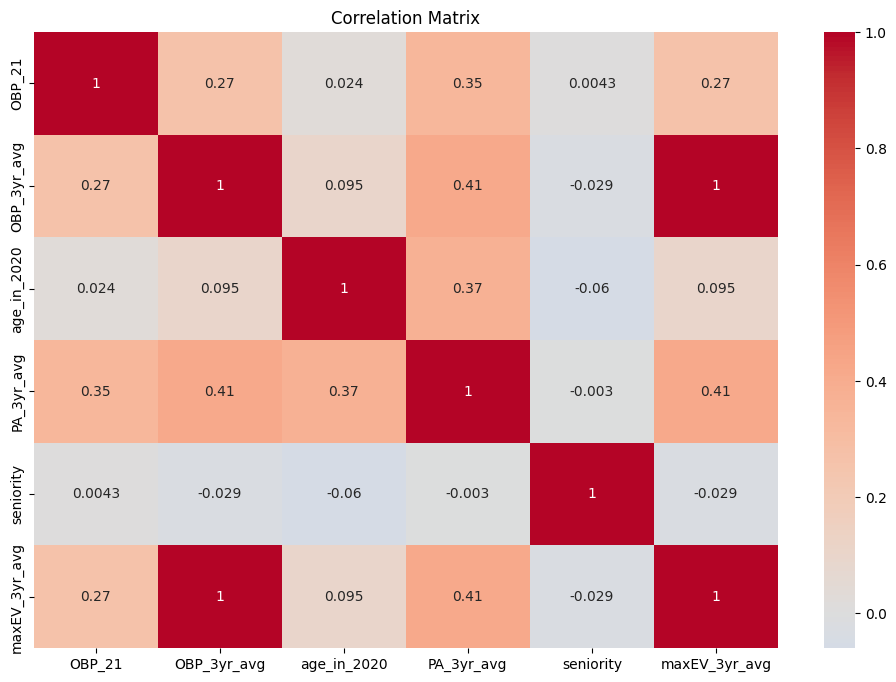

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
key_variables=['OBP_21','OBP_3yr_avg','age_in_2020',
               'PA_3yr_avg','seniority',
       'maxEV_3yr_avg']

plt.figure(figsize=(12, 8))
corr_matrix = data6[key_variables].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

Direct Influence: While maxEV does not directly influence OBP in the way that walks (BB), hits (H), hit-by-pitches (HBP), and at-bats (AB) do (since these are the components used to calculate OBP), it indirectly suggests a player's ability to make strong contact with the ball. Stronger contact can lead to more hits, which can improve OBP.

Indirect Correlation: A higher maxEV indicate that when the player does hit the ball, they are more likely to get on base due to the quality of contact. However, maxEV alone does not account for a player’s ability to draw walks or avoid strikeouts, which are also crucial for a good OBP. So then, I will use this variable to predict OBP in 2021.

In [130]:
data6.to_parquet('/content/drive/MyDrive/USA/PHILLIES-beisbal/obp_4.parquet')

Weird that seniority is negatively correlated. If it makes sense to the business then keep it, otherwise is better to remove it.

In [131]:
len(data6)

506

In [132]:
# Calculating number of nulls in each column
null_counts = data6.isna().sum()

# Printing the number of nulls per column
print(null_counts)


Name                  0
playerid              0
birth_date            0
PA_21                 0
OBP_21                0
                   ... 
maxEV_3yr_avg         0
xwOBA_3yr_avg       506
L-WAR_3yr_avg       191
HardHit%_3yr_avg    191
CSW%_3yr_avg        191
Length: 68, dtype: int64


#### Model - Random Forest

In [96]:
features=['OBP_3yr_avg','age_in_2020',
               'PA_3yr_avg',
       'maxEV_3yr_avg']

In [103]:
target = 'OBP_21'

df = data6[features + [target]]
X = df[features]
y = df[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [104]:
# Split the set

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

##### Fitting the model

In [105]:
# Train a Random Forest model with hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_



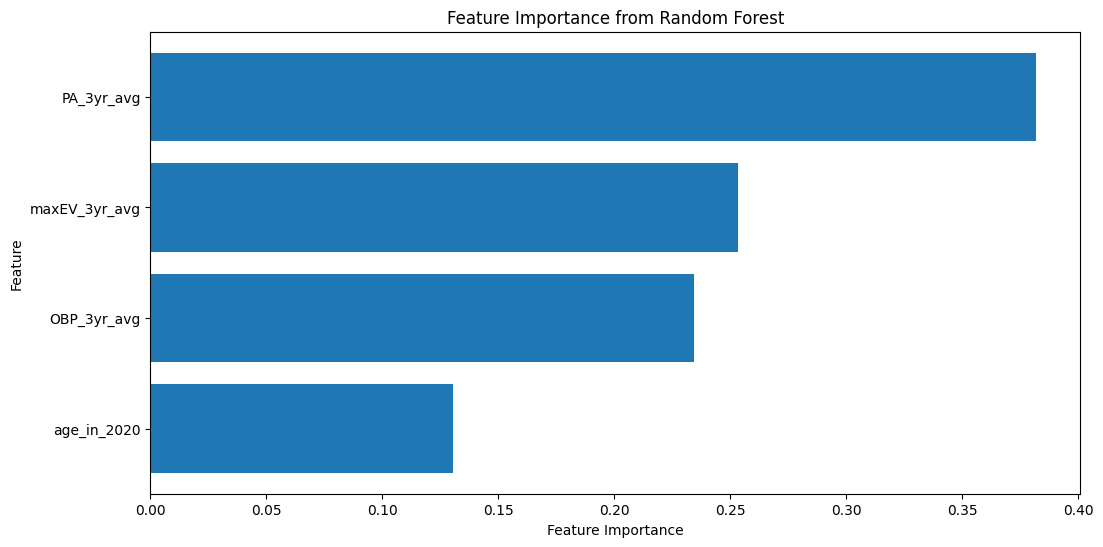

,Feature,Importance
2,PA_3yr_avg,0.381792
3,maxEV_3yr_avg,0.253379
0,OBP_3yr_avg,0.234355
1,age_in_2020,0.130474


In [106]:
import matplotlib.pyplot as plt

# Get feature importances
importances = best_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

importance_df


In [145]:
import pickle
# Save the model
with open('/content/drive/MyDrive/USA/PHILLIES-beisbal/random_forest_model2.pkl', 'wb') as file:
    pickle.dump(best_model, file)

**GAIN** The new variable maxEV_3yr_avg help to improve the model in general. The importance of such variable to predict OBP is even higher than 2 of the existing variables used to predict. The marginal increase of the R2 is aditively 11% on training and 3% on test over the last RF model that does not include maxEV_3yr_avg.

Best hyperparameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100}
Best R² score during training: 0.10831160041613193
Training R²: 0.4409091620941371
Training RMSE: 0.03529810706289717
Training MAE: 0.02720609769776196
Test R²: 0.23086518147611523
Test RMSE: 0.048887559241603123
Test MAE: 0.036666997302129696


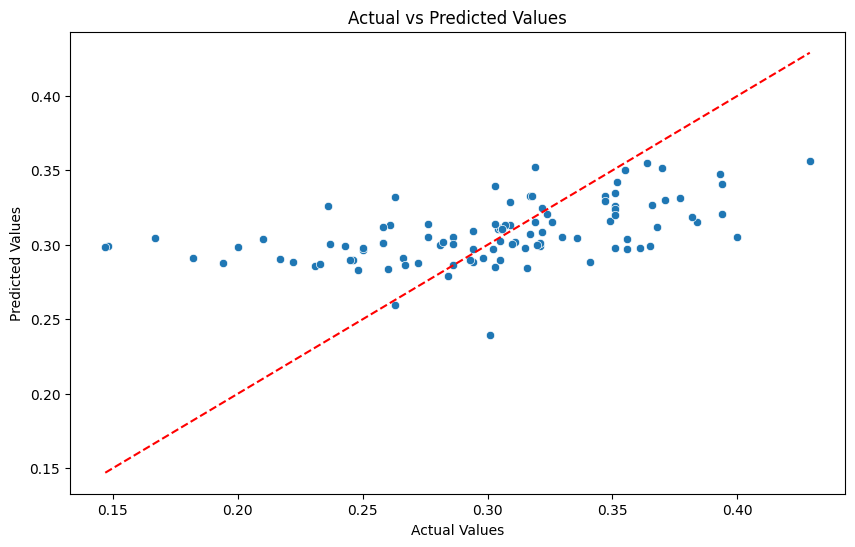

In [109]:
# Print the best hyperparameters and R2 score
print("Best hyperparameters:", grid_search.best_params_)
print("Best R² score during training:", grid_search.best_score_)

# Evaluate the model on the training set
y_train_pred = best_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)
print("Training R²:", train_r2)
print("Training RMSE:", train_rmse)
print("Training MAE:", train_mae)

# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)
print("Test R²:", test_r2)
print("Test RMSE:", test_rmse)
print("Test MAE:", test_mae)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, marker='o')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()


## Other sources - No explored

### Savant

I explore the data source https://baseballsavant.mlb.com/leaderboard/bat-tracking and extract the csv from it, I did not had chance to add more analysis on it but I would be happy to do it as a next step when working for Phillies

In [156]:
btracking=pd.read_csv('/content/bat-tracking (1).csv')
btracking[:5]



,id,name,swings_competitive,percent_swings_competitive,contact,avg_bat_speed,hard_swing_rate,squared_up_per_bat_contact,squared_up_per_swing,blast_per_bat_contact,blast_per_swing,swing_length,swords,batter_run_value,whiffs,whiff_per_swing,batted_ball_events,batted_ball_event_per_swing
0,519317,"Stanton, Giancarlo",422,0.915401,293,80.756903,0.981043,0.296928,0.206161,0.269625,0.187204,8.396827,4,6.050566,129,0.305687,150,0.355450
1,665833,"Cruz, Oneil",349,0.908854,243,77.967003,0.747851,0.329218,0.229226,0.226337,0.157593,7.624194,3,-10.455551,106,0.303725,118,0.338109
2,656941,"Schwarber, Kyle",430,0.901468,301,77.203472,0.751163,0.332226,0.232558,0.229236,0.160465,7.833519,16,-3.368513,129,0.300000,154,0.358140
3,656305,"Chapman, Matt",460,0.905512,345,76.831284,0.671739,0.252174,0.189130,0.173913,0.130435,7.410876,8,-11.345515,115,0.250000,153,0.332609
4,666176,"Adell, Jo",397,0.906393,272,76.773139,0.662469,0.264706,0.181360,0.165441,0.113350,7.674886,6,-8.531479,125,0.314861,120,0.302267


### ESPN
It has an API that can be used to retrieve more data, in this case I would love to explore the API with a little more of time to do it. I will provide a simple example on how to use the API
https://www.espn.com/mlb/

In [146]:
pip install espn_api


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 2.5 MB/s eta 0:00:00


In [ ]:
from espn_api.baseball import League

league_id = 123456
year = 2021
espn_s2 = 'Your_espn_s2_cookie'
swid = 'Your_SWID_cookie'

league = League(league_id=league_id, year=year, espn_s2=espn_s2, swid=swid)

print("League Name:", league.settings.name)
print("Teams in League:")
for team in league.teams:
    print(team.team_name, team.owner)

# Accessing some stats and standings
standings = league.standings()
print("Standings:")
for team in standings:
    print(team.team_name, team.wins, team.losses)


### STATS API https://statsapi.mlb.com - Exploring web scraping

With more time this would be a really good option as the data seems very good too

In [ ]:
import requests
key_mlbam = 572204
# MLB Stats API endpoint structure
url = f"https://statsapi.mlb.com/api/v1/people/{key_mlbam}"
response = requests.get(url)
data = response.json()
print(data)


{'copyright': 'Copyright 2024 MLB Advanced Media, L.P.  Use of any content on this page acknowledges agreement to the terms posted here http://gdx.mlb.com/components/copyright.txt', 'people': [{'id': 572204, 'fullName': 'Trayce Thompson', 'link': '/api/v1/people/572204', 'firstName': 'Trayce', 'lastName': 'Thompson', 'primaryNumber': '43', 'birthDate': '1991-03-15', 'currentAge': 33, 'birthCity': 'Los Angeles', 'birthStateProvince': 'CA', 'birthCountry': 'USA', 'height': '6\' 3"', 'weight': 225, 'active': True, 'primaryPosition': {'code': '9', 'name': 'Outfielder', 'type': 'Outfielder', 'abbreviation': 'RF'}, 'useName': 'Trayce', 'useLastName': 'Thompson', 'middleName': 'Nikolas', 'boxscoreName': 'Thompson, T', 'nickName': "Rocco's Uncle", 'gender': 'M', 'isPlayer': True, 'isVerified': True, 'draftYear': 2009, 'mlbDebutDate': '2015-08-04', 'batSide': {'code': 'R', 'description': 'Right'}, 'pitchHand': {'code': 'R', 'description': 'Right'}, 'nameFirstLast': 'Trayce Thompson', 'nameSlug'

### Baseball Reference - Exploring web scraping

With more time this would be a really good option as the data seems very good

In [147]:
import requests
from bs4 import BeautifulSoup

# Define the URL
url = f"https://www.baseball-reference.com/players/s/stantmi03.shtml"

response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Example: Scrape career home runs
career_home_runs = soup.find('div', id='all_batting_standard').find_all('tr')[-1].find('td', {'data-stat': 'HR'}).text

print(f"Giancarlo Stanton Career Home Runs: {career_home_runs}")


Giancarlo Stanton Career Home Runs: 153


In [ ]:
pip install pybaseball

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.3.0
    Uninstalling PyJWT-2.3.0:
      Successfully uninstalled PyJWT-2.3.0


In [ ]:
from pybaseball import statcast

In [ ]:
statcast(start_dt="2019-06-24", end_dt="2019-06-25").columns

This is a large query, it may take a moment to complete


100%|██████████| 2/2 [00:12<00:00,  6.47s/it]


Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [ ]:
from pybaseball import  playerid_lookup
from pybaseball import  statcast_pitcher
a=playerid_lookup('kershaw', 'clayton')
a

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,kershaw,clayton,477132,kersc001,kershcl01,2036,2008.0,2023.0


In [ ]:
from pybaseball import pitching_stats
data = pitching_stats(2016,2023)
data.columns

Index(['IDfg', 'Season', 'Name', 'Team', 'Age', 'W', 'L', 'WAR', 'ERA', 'G',
       ...
       'Pit+ FC', 'Stf+ FS', 'Loc+ FS', 'Pit+ FS', 'Stuff+', 'Location+',
       'Pitching+', 'Stf+ FO', 'Loc+ FO', 'Pit+ FO'],
      dtype='object', length=393)

In [ ]:
data

,IDfg,Season,Name,Team,Age,W,L,WAR,ERA,G,...,Pit+ FC,Stf+ FS,Loc+ FS,Pit+ FS,Stuff+,Location+,Pitching+,Stf+ FO,Loc+ FO,Pit+ FO
1,10954,2018,Jacob deGrom,NYM,30,10,9,9.0,1.70,32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,10603,2017,Chris Sale,BOS,28,17,8,7.6,2.90,32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,13125,2019,Gerrit Cole,HOU,28,20,5,7.5,2.50,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,3137,2018,Max Scherzer,WSN,33,18,7,7.5,2.53,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,19361,2021,Corbin Burnes,MIL,26,11,5,7.5,2.43,28,...,115.0,NaN,NaN,NaN,143.0,104.0,111.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,15474,2018,Lucas Giolito,CHW,23,10,13,0.1,6.13,32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339,13834,2020,Alec Mills,CHC,28,5,5,0.1,4.48,11,...,NaN,NaN,NaN,NaN,86.0,103.0,100.0,NaN,NaN,NaN
280,15467,2022,Marco Gonzales,SEA,30,10,15,0.0,4.13,32,...,90.0,NaN,NaN,NaN,84.0,103.0,95.0,NaN,NaN,NaN
418,15440,2020,Matthew Boyd,DET,29,3,7,-0.1,6.71,12,...,NaN,NaN,NaN,NaN,78.0,97.0,95.0,NaN,NaN,NaN
